#REPRODUÇÃO DE ARTIGO CIENTÍFICO#

##Instalações iniciais para que o SciANN possa funcionar

In [ ]:
! pip uninstall -y keras tensorflow
! pip install tensorflow==2.12
! pip install sciann


Found existing installation: keras 2.12.0
Uninstalling keras-2.12.0:
  Successfully uninstalled keras-2.12.0
Found existing installation: tensorflow 2.12.0
Uninstalling tensorflow-2.12.0:
  Successfully uninstalled tensorflow-2.12.0
  Using cached tensorflow-2.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
  Using cached keras-2.12.0-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached tensorflow-2.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (586.0 MB)
Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.12.0 which is incompatible.
keras-hub 0.21.1 requires keras>=3.5, but you have keras 2.12.0 which is incompatible.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you ha

##Os códigos abaixo referem-se ao artigo:

* A deep learning framework for solution and discovery in solid mechanics

* https://doi.org/10.48550/arXiv.2003.02751

* fonte:https://github.com/ehsanhaghighat/sciann-applications/tree/master/SciANN-SolidMechanics-BCs

Training started...

Total samples: 400 
Batch size: 32 
Total batches: 13 

Epoch 1/5000
13/13 - 4s - loss: 2043.9504 - Uxy_loss: 0.4549 - Vxy_loss: 0.1234 - Sxx_loss: 2.2894 - Syy_loss: 7.6854 - Sxy_loss: 1.6264 - sub_7_loss: 1.0046 - sub_8_loss: 0.7903 - sub_9_loss: 0.1605 - add_17_loss: 1755.6979 - add_18_loss: 262.6677 - lr: 0.0010 - time: 3.8449 - 4s/epoch - 296ms/step
Epoch 2/5000
13/13 - 0s - loss: 1991.6389 - Uxy_loss: 0.1757 - Vxy_loss: 0.1102 - Sxx_loss: 2.8614 - Syy_loss: 6.0173 - Sxy_loss: 2.0571 - sub_7_loss: 0.2658 - sub_8_loss: 0.2604 - sub_9_loss: 0.2825 - add_17_loss: 1711.2412 - add_18_loss: 250.9575 - lr: 0.0010 - time: 0.0850 - 85ms/epoch - 7ms/step
Epoch 3/5000
13/13 - 0s - loss: 1920.5835 - Uxy_loss: 0.1468 - Vxy_loss: 0.1281 - Sxx_loss: 3.9612 - Syy_loss: 5.4730 - Sxy_loss: 2.3107 - sub_7_loss: 0.1688 - sub_8_loss: 0.1264 - sub_9_loss: 0.1252 - add_17_loss: 1660.9008 - add_18_loss: 239.8794 - lr: 0.0010 - time: 0.1096 - 110ms/epoch - 8ms/step
Epoch 4/5000
13/13 

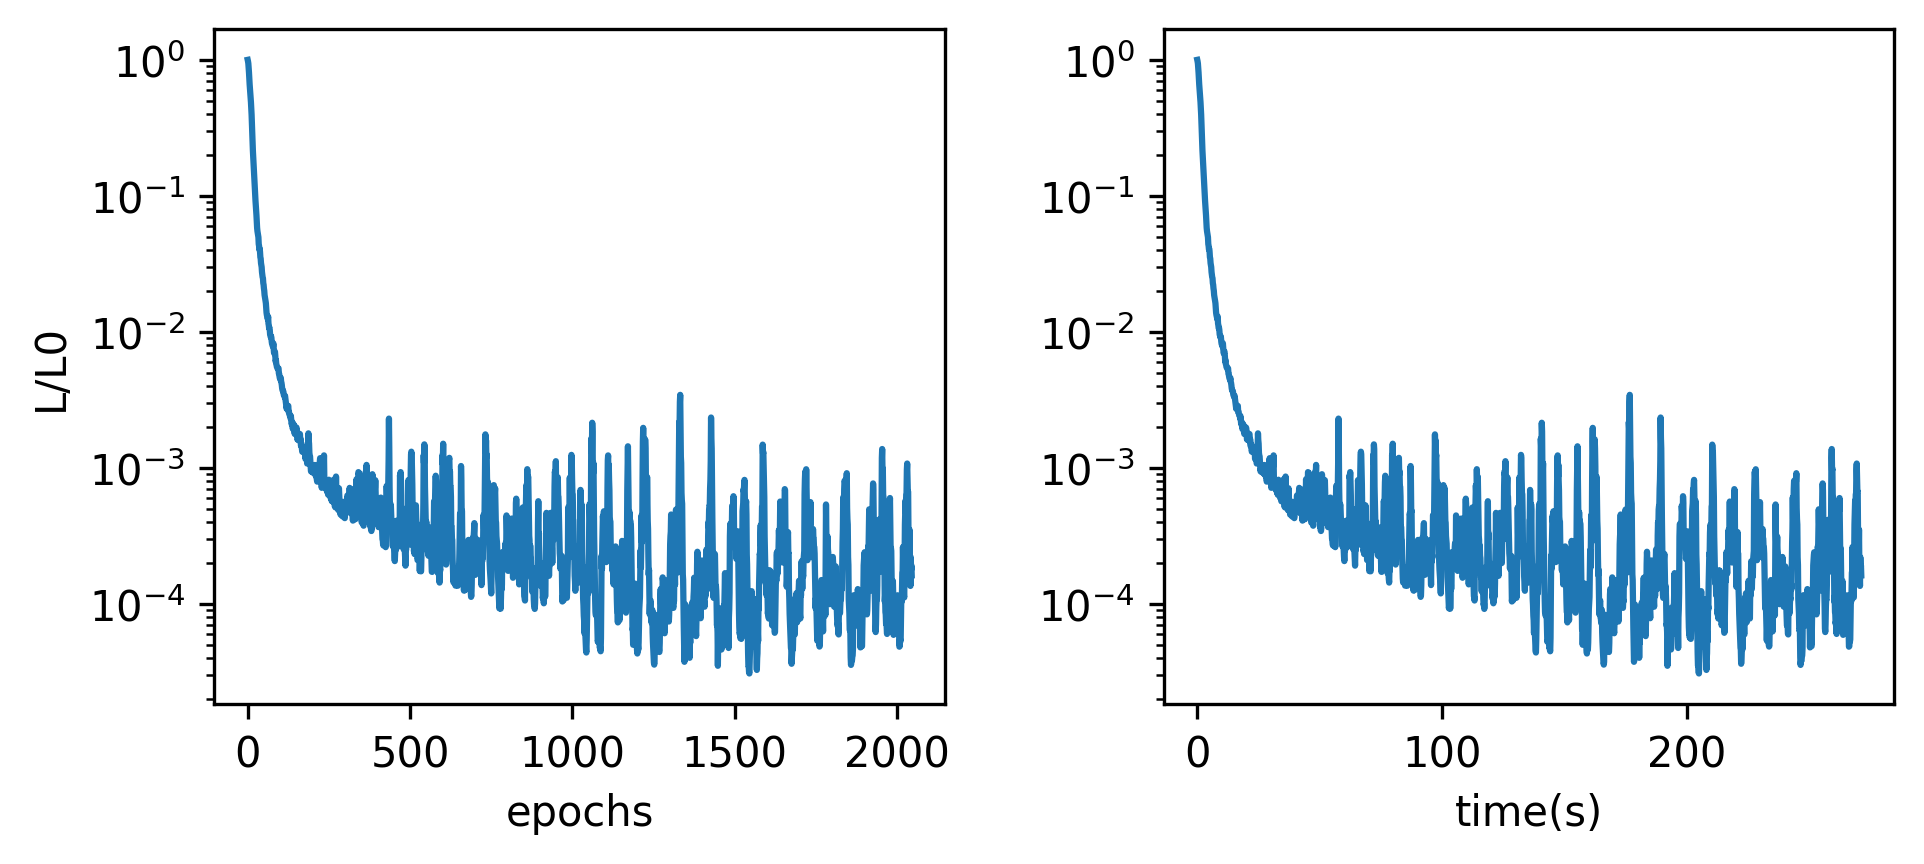

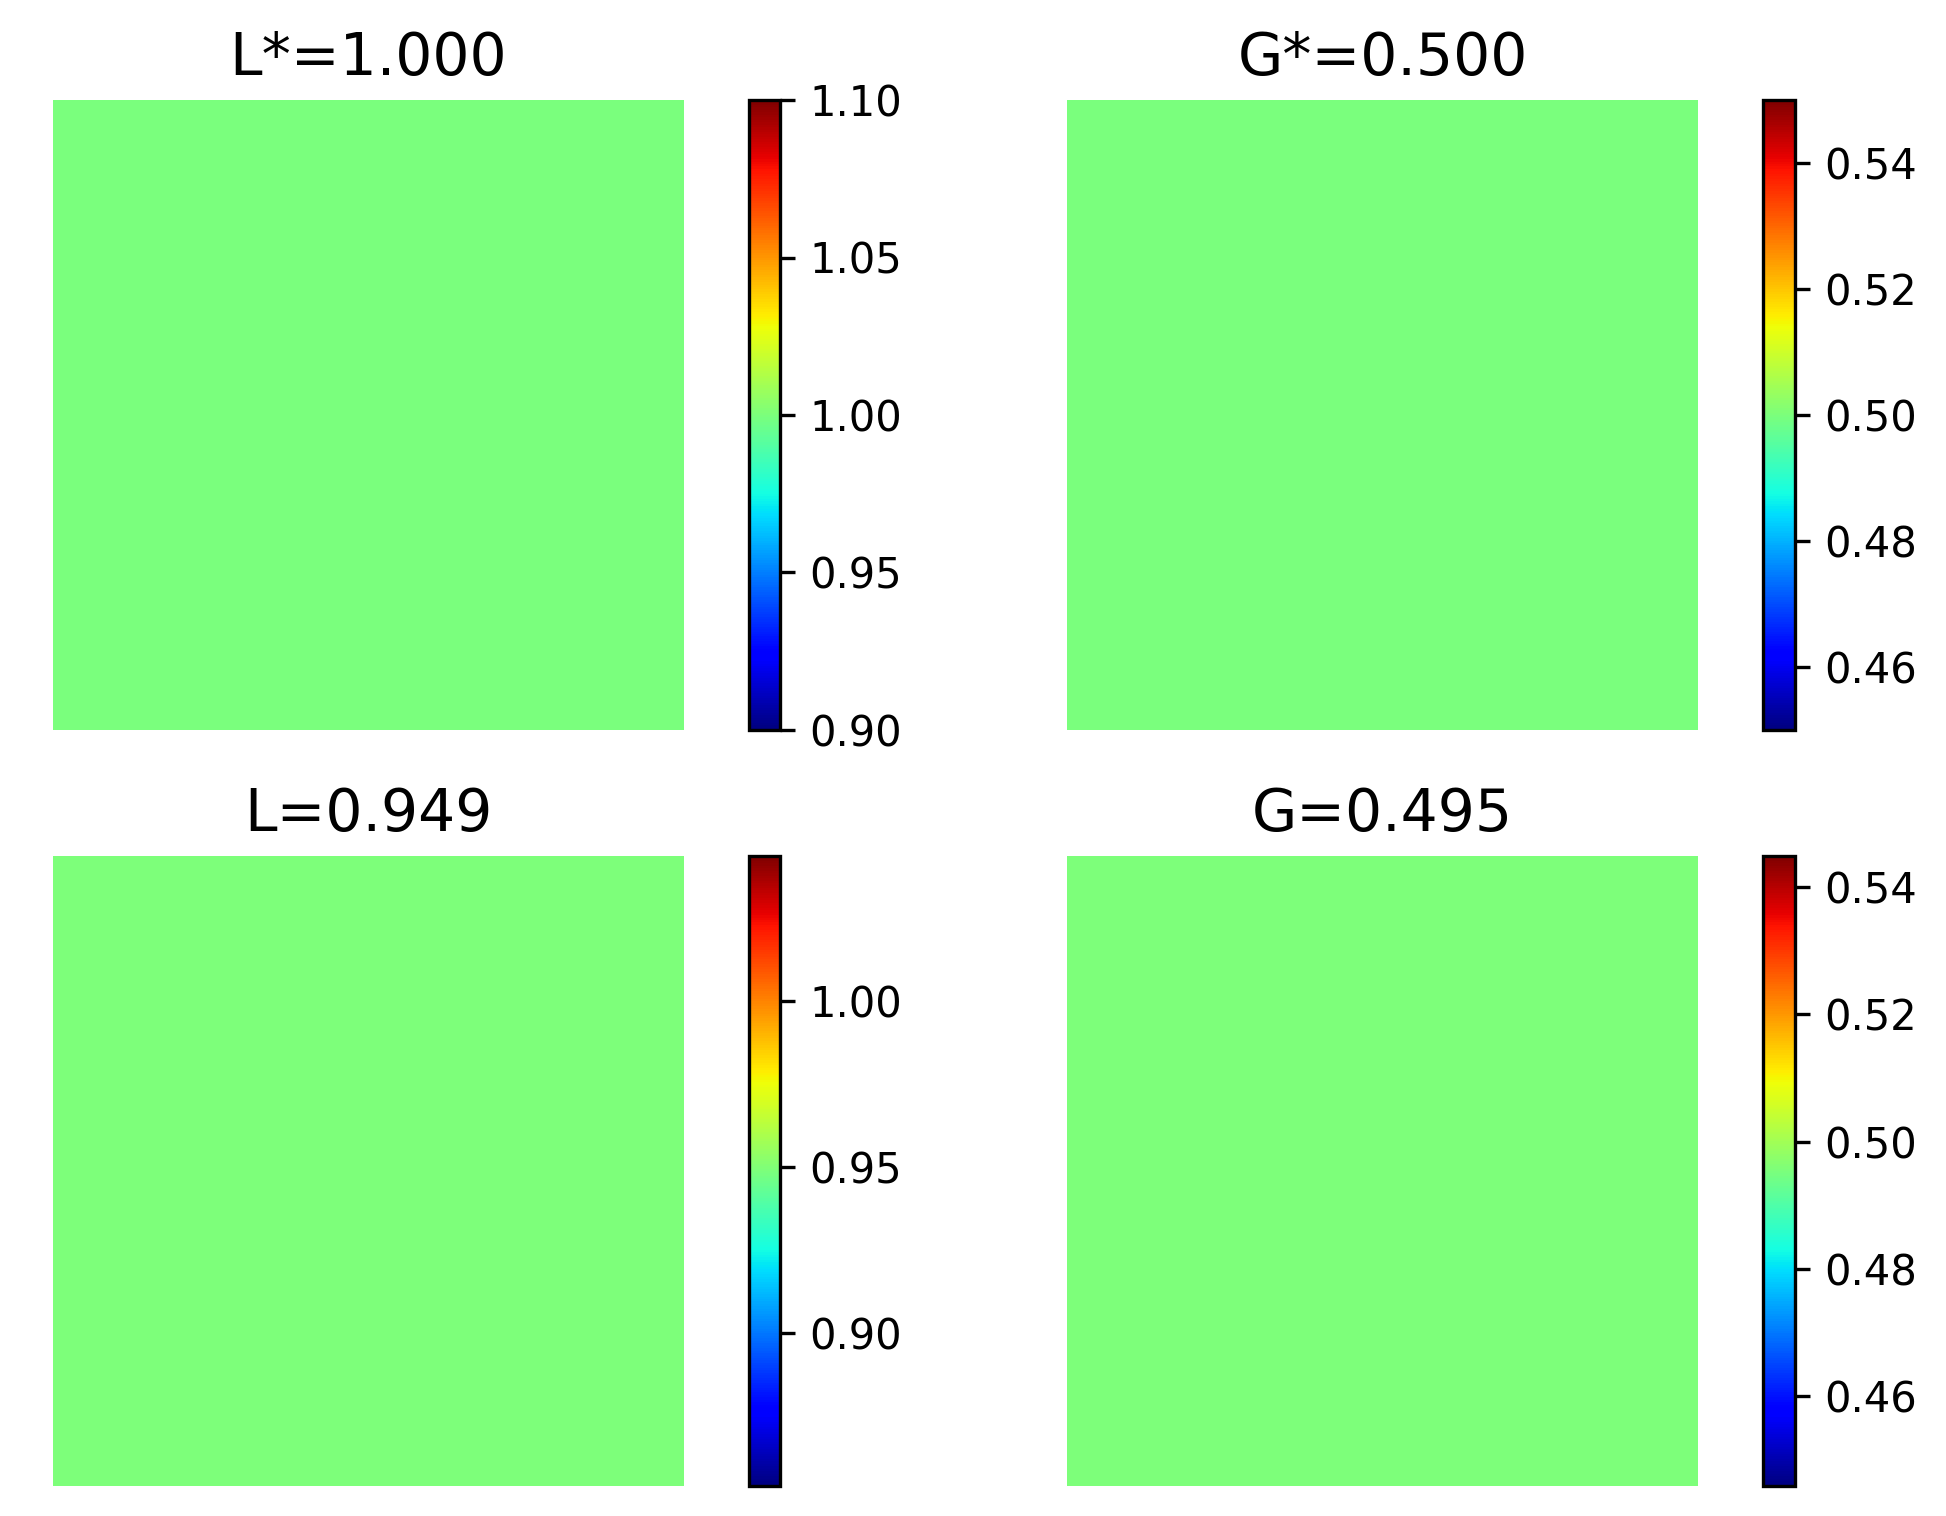

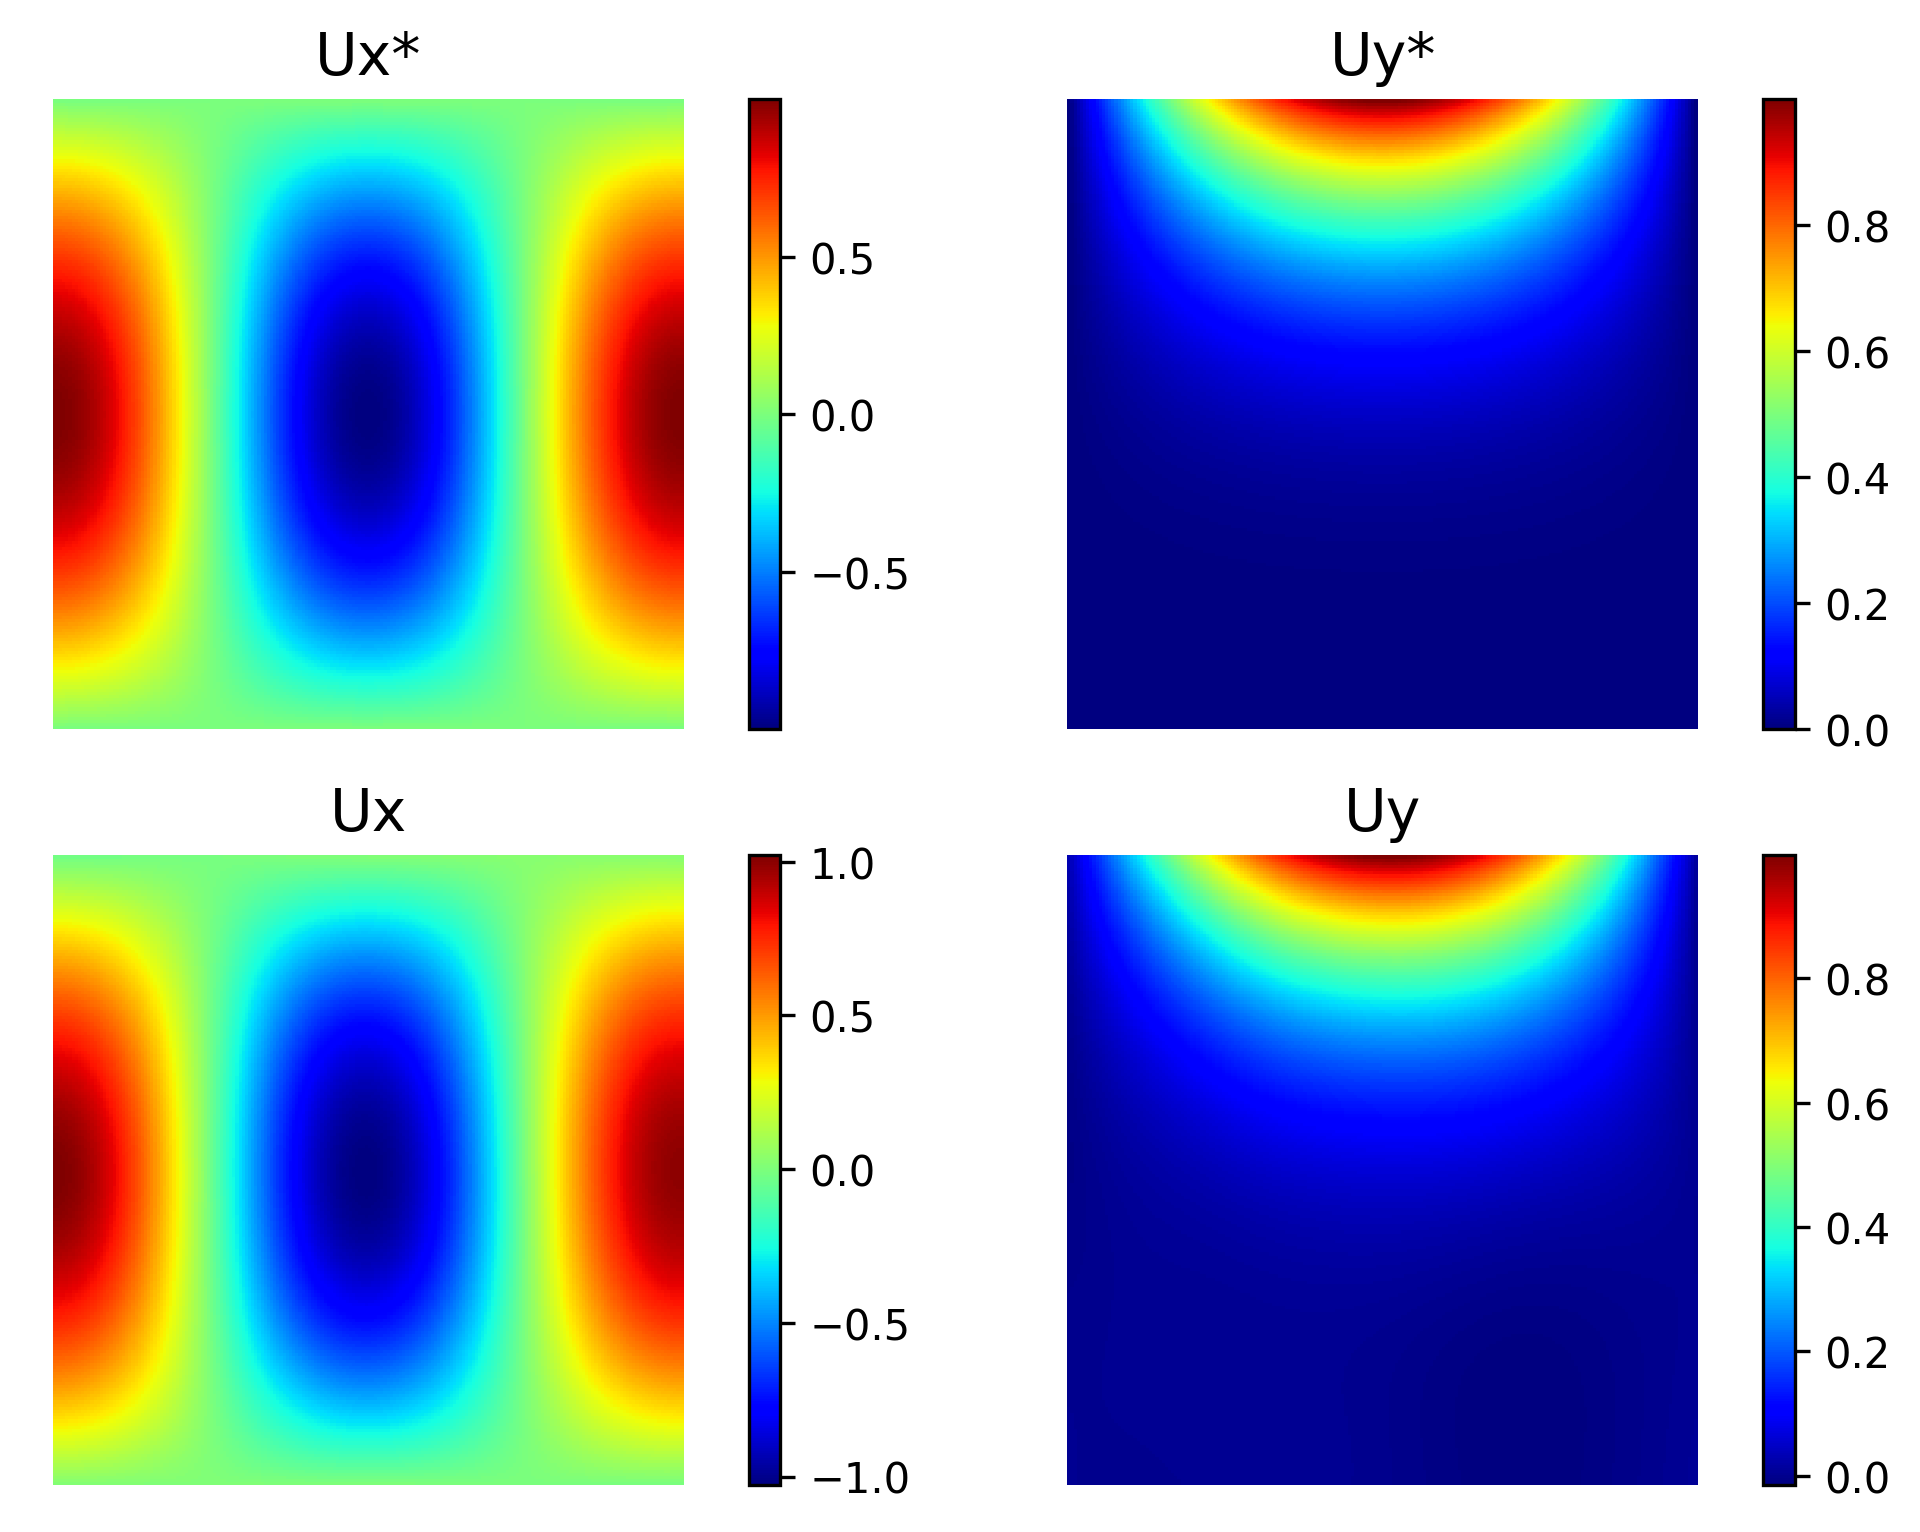

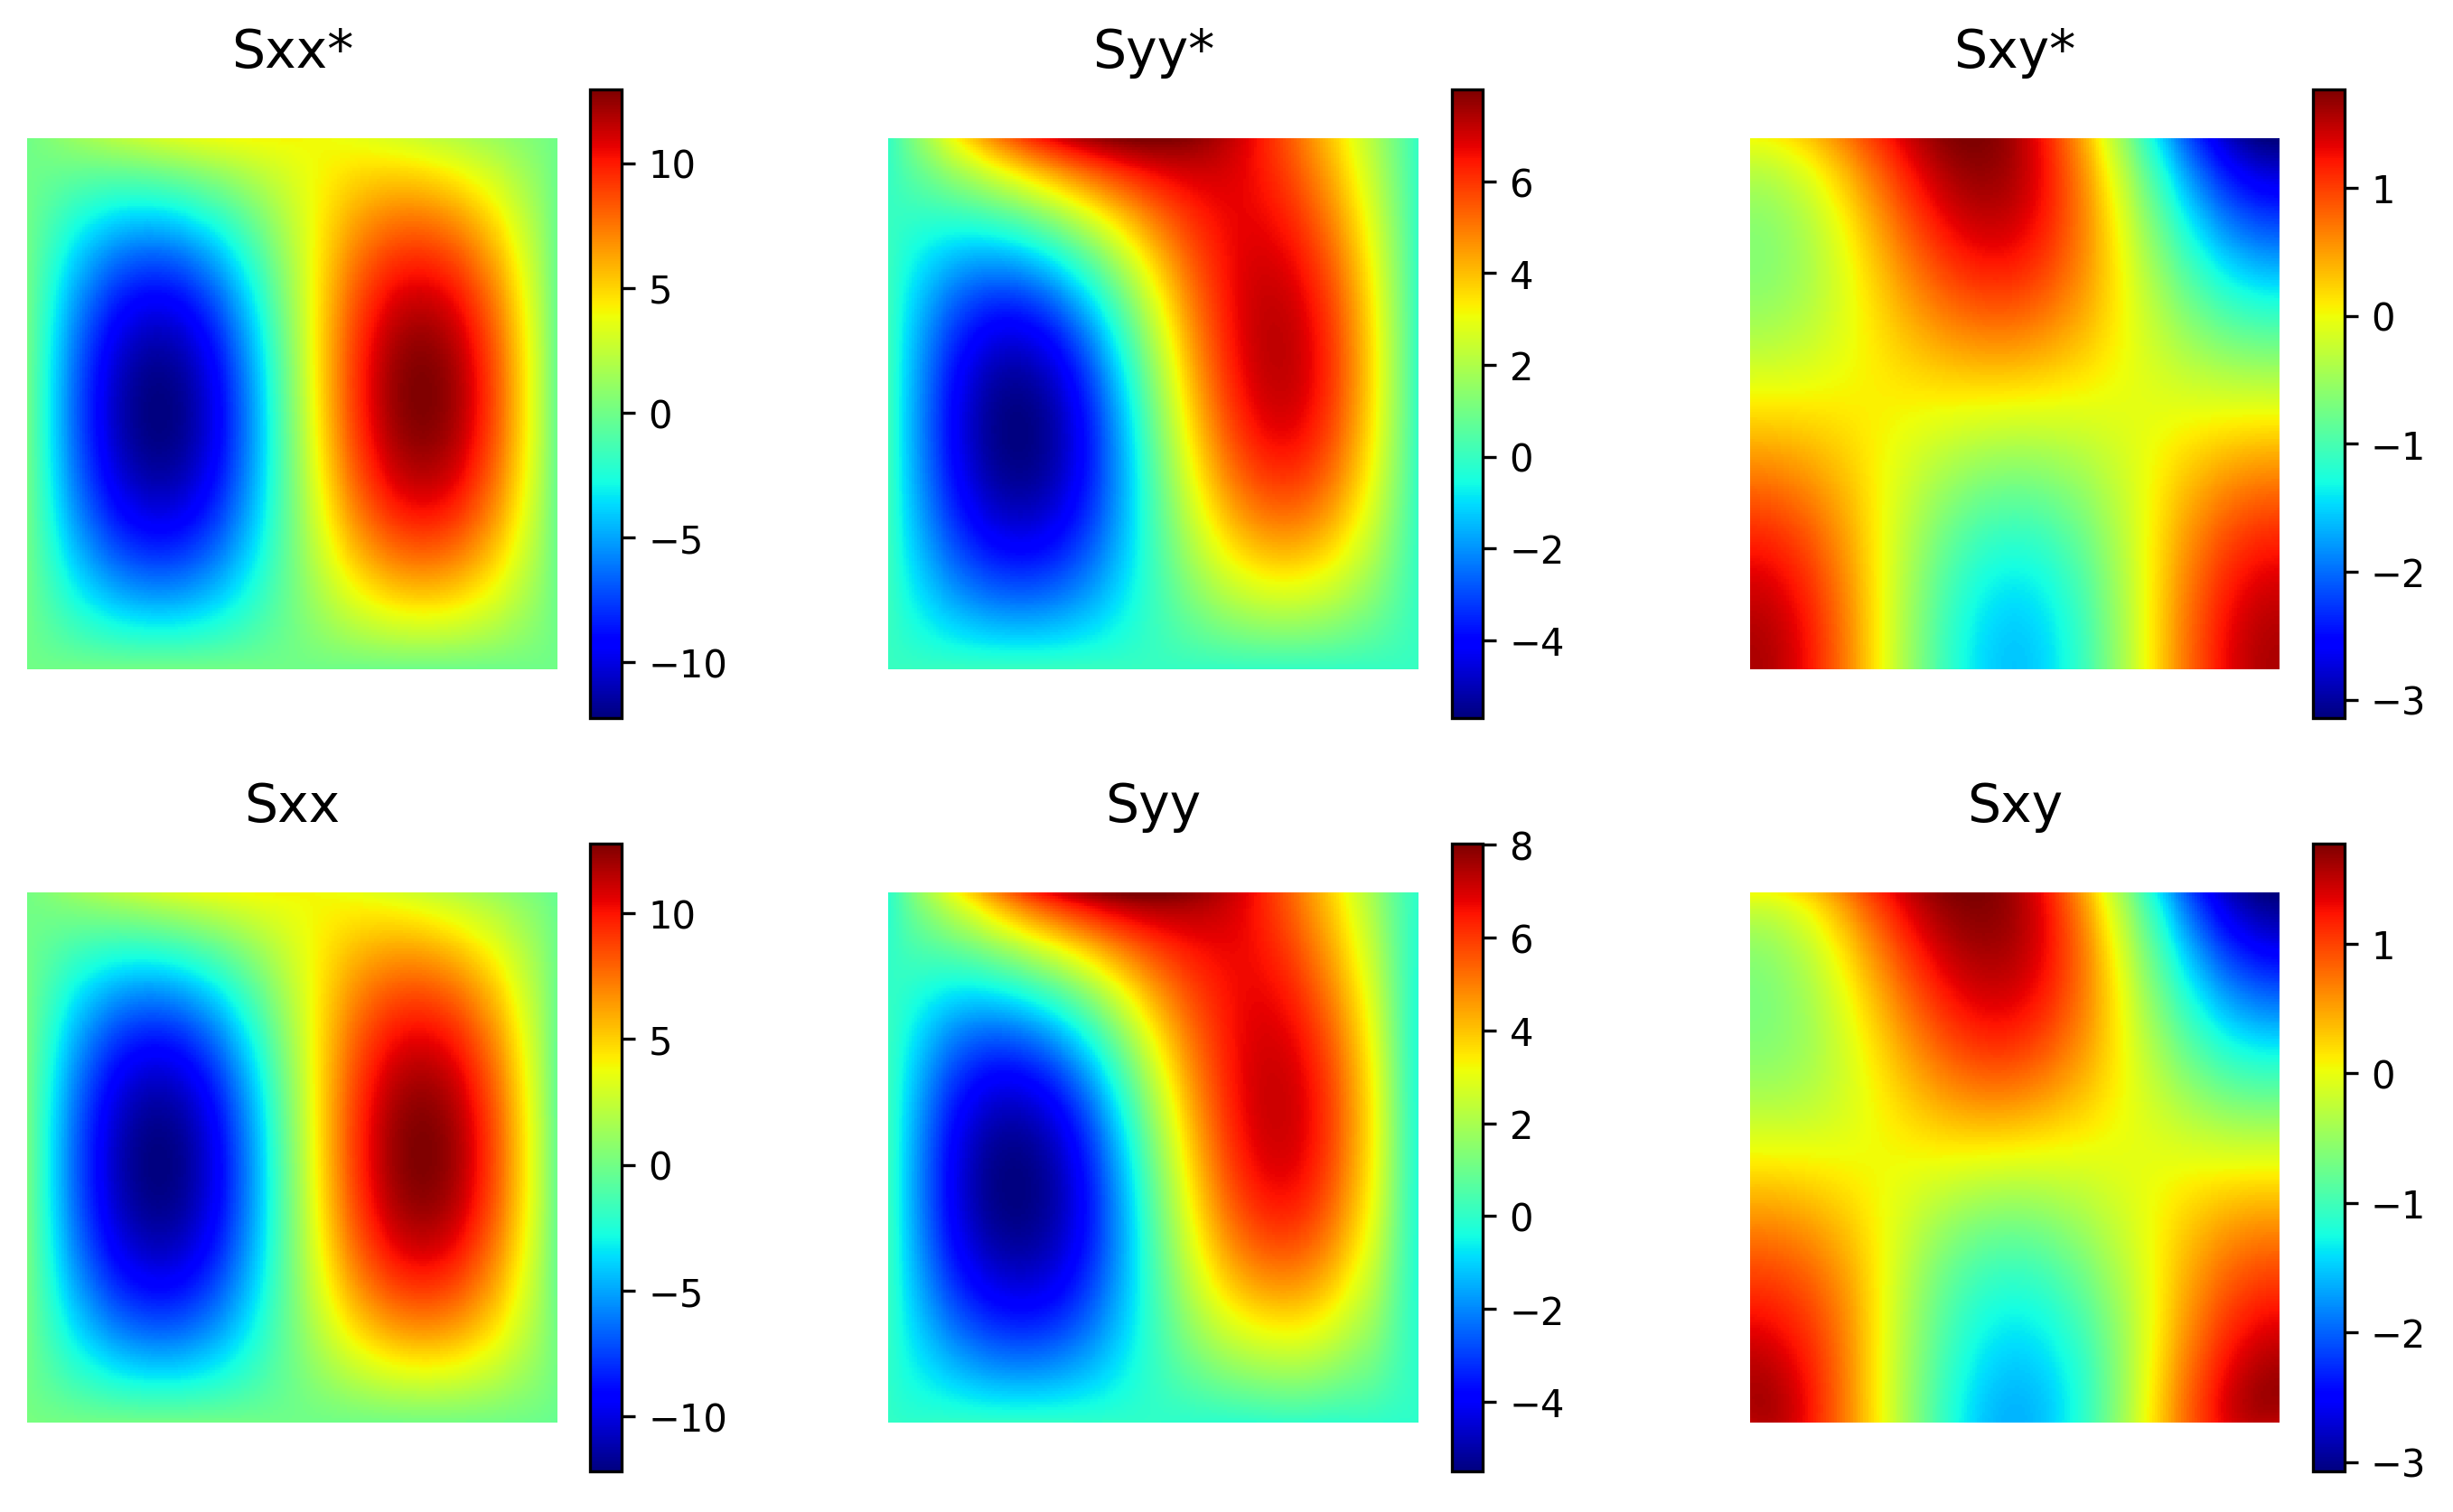

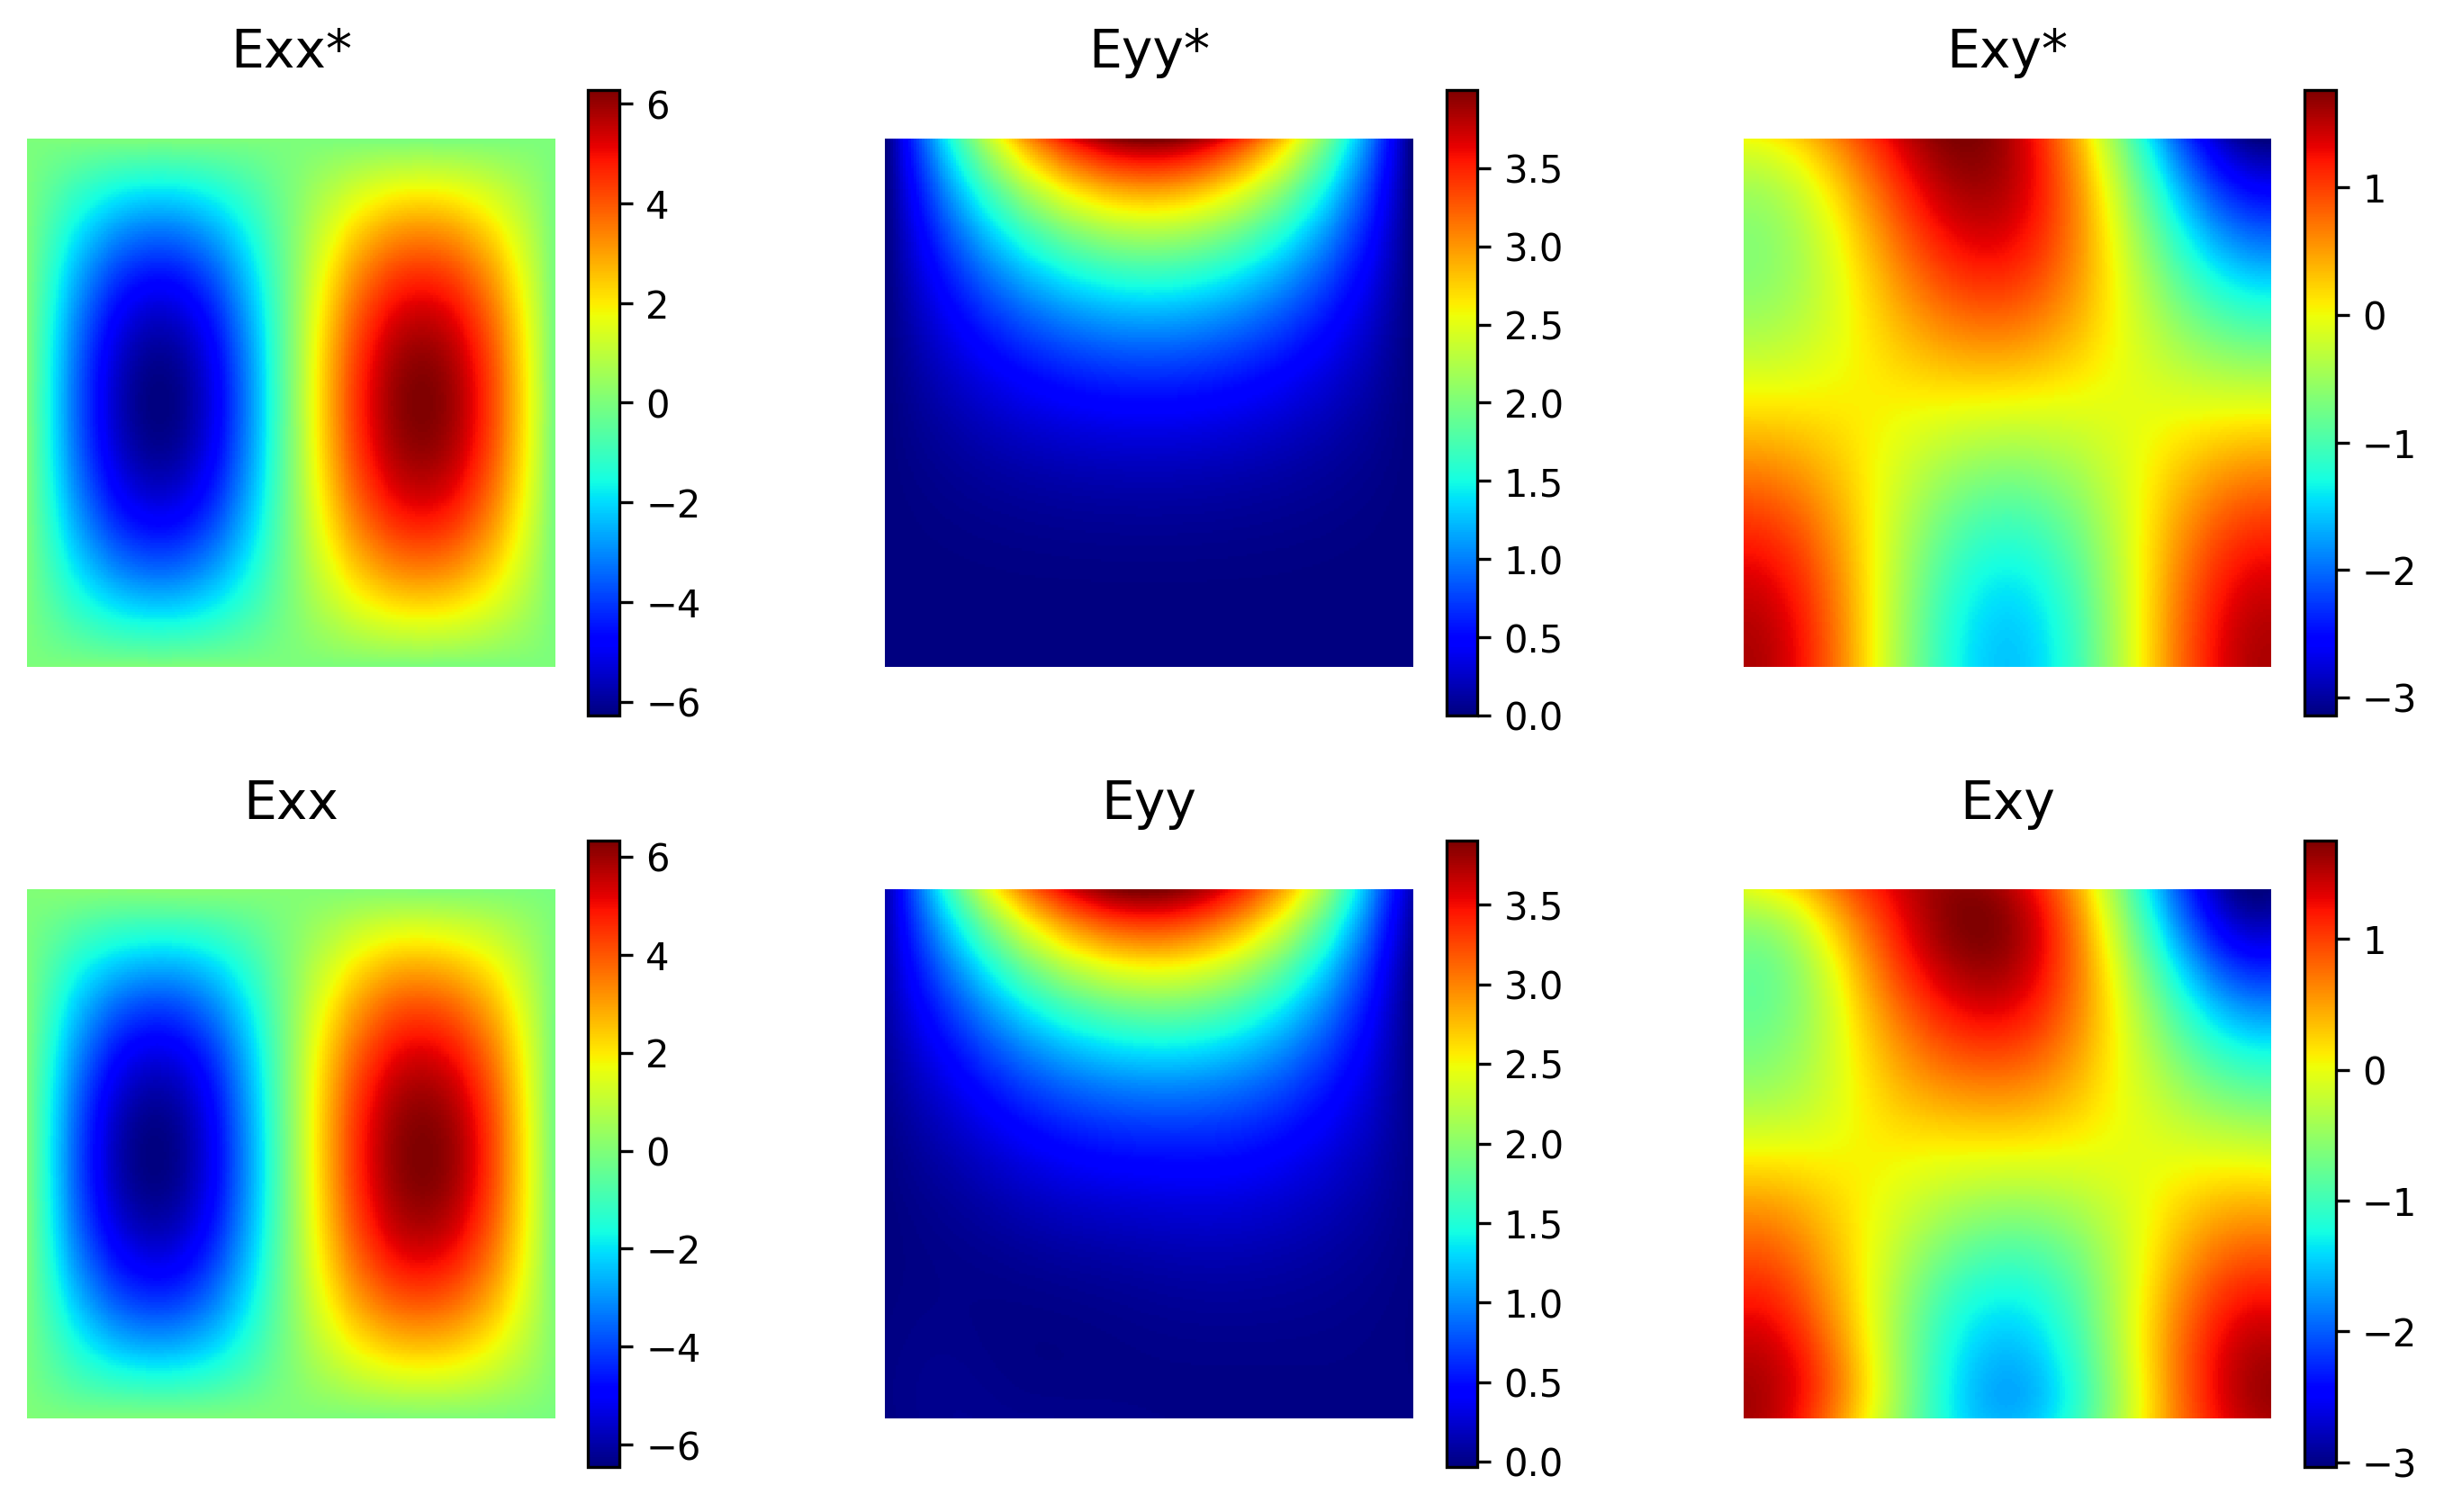

In [ ]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from sciann.utils.math import diff
from sciann import SciModel, Functional, Parameter, Variable, Data, Tie

pi = np.pi

# Parâmetros fixos do problema
lmbd = 1.0
mu = 0.5
qload = 4.0

# Configurações manuais (em vez de argparse)
args = {
    "layers": [40, 40, 40, 40],
    "actf": ["tanh"],
    "numx": [20],
    "numy": [20],
    "batchsize": [32],
    "epochs": [5000],
    "learningrate": [0.001],
    "independent_networks": [True],
    "verbose": [2],
    "shuffle": [True],
    "stopafter": [500],
    "savefreq": [100000],
    "dtype": ["float64"],
    "gpu": [False],
    "outputpath": ["output"],
    "outputprefix": ["res"],
    "numxplot": [200],
    "numyplot": [200],
    "plot": False,
}

# Desliga GPU no Colab se quiser (por padrão False)
if not args["gpu"][0]:
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Funções definidas no seu código original
def load(xx):
    x, y = xx[0], xx[1]
    Q = qload
    return Q * np.sin(pi*x)

def bodyfx(xx):
    x, y = xx[0], xx[1]
    Q = qload
    frc = - lmbd*(4*pi**2*np.cos(2*pi*x)*np.sin(pi*y) - Q*y**3*pi*np.cos(pi*x)) \
          - mu*(pi**2*np.cos(2*pi*x)*np.sin(pi*y) - Q*y**3*pi*np.cos(pi*x)) \
          - 8*mu*pi**2*np.cos(2*pi*x)*np.sin(pi*y)
    return frc

def bodyfy(xx):
    x, y = xx[0], xx[1]
    Q = qload
    frc = lmbd*(3*Q*y**2*np.sin(pi*x) - 2*pi**2*np.cos(pi*y)*np.sin(2*pi*x)) \
          - mu*(2*pi**2*np.cos(pi*y)*np.sin(2*pi*x) + (Q*y**4*pi**2*np.sin(pi*x))/4) \
          + 6*Q*mu*y**2*np.sin(pi*x)
    return frc

def dispx(xx):
    x, y = xx[0], xx[1]
    return np.cos(2*pi*x) * np.sin(pi*y)

def dispy(xx):
    x, y = xx[0], xx[1]
    Q = qload
    return np.sin(pi*x) * Q * y**4/4

def strainxx(xx):
    x, y = xx[0], xx[1]
    Q = qload
    return -2*pi*np.sin(2*pi*x)*np.sin(pi*y)

def strainyy(xx):
    x, y = xx[0], xx[1]
    Q = qload
    return np.sin(pi*x)*Q*y**3

def strainxy(xx):
    x, y = xx[0], xx[1]
    Q = qload
    return 0.5*(pi*np.cos(2*pi*x)*np.cos(pi*y) + pi*np.cos(pi*x)*Q*y**4/4)

def stressxx(xx):
    return (lmbd+2*mu)*strainxx(xx) + lmbd*strainyy(xx)

def stressyy(xx):
    return (lmbd+2*mu)*strainyy(xx) + lmbd*strainxx(xx)

def stressxy(xx):
    return 2.0*mu*strainxy(xx)

def cust_pcolor(AX, X, Y, C, title):
    im = AX.pcolor(X, Y, C, cmap="jet")
    AX.axis("equal")
    AX.axis("off")
    AX.set_title(title, fontsize=14)
    plt.colorbar(im, ax=AX)

def cust_semilogx(AX, X, Y, xlabel, ylabel):
    if X is None:
        im = AX.semilogy(Y)
    else:
        im = AX.semilogy(X, Y)
    if xlabel is not None: AX.set_xlabel(xlabel)
    if ylabel is not None: AX.set_ylabel(ylabel)

def train():
    # Prepare output folder
    if not os.path.isdir(args["outputpath"][0]):
        os.mkdir(args["outputpath"][0])

    output_file_name = os.path.join(args["outputpath"][0], args["outputprefix"][0])
    fname = output_file_name + "_{}_".format(args["actf"][0]) + "x".join([str(x) for x in args["layers"]])

    # Neural Network Setup
    x = Variable("x", dtype=args["dtype"][0])
    y = Variable("y", dtype=args["dtype"][0])

    if args["independent_networks"][0]:
        Uxy = Functional("Uxy", [x, y], args["layers"], args["actf"][0])
        Vxy = Functional("Vxy", [x, y], args["layers"], args["actf"][0])
        Sxx = Functional("Sxx", [x, y], args["layers"], args["actf"][0])
        Syy = Functional("Syy", [x, y], args["layers"], args["actf"][0])
        Sxy = Functional("Sxy", [x, y], args["layers"], args["actf"][0])
    else:
        Uxy, Vxy, Sxx, Syy, Sxy = Functional(
            ["Uxy", "Vxy", "Sxx", "Syy", "Sxy"],
            [x, y],
            args["layers"], args["actf"][0]).split()

    lame1 = Parameter(2.0, inputs=[x,y], name="lame1")
    lame2 = Parameter(2.0, inputs=[x,y], name="lame2")

    C11 = (2*lame2 + lame1)
    C12 = lame1
    C33 = 2*lame2

    Exx = diff(Uxy, x)
    Eyy = diff(Vxy, y)
    Exy = 0.5*(diff(Uxy, y) + diff(Vxy, x))

    # Define constraints
    d1 = Data(Uxy)
    d2 = Data(Vxy)
    d3 = Data(Sxx)
    d4 = Data(Syy)
    d5 = Data(Sxy)

    c1 = Tie(Sxx, Exx*C11 + Eyy*C12)
    c2 = Tie(Syy, Eyy*C11 + Exx*C12)
    c3 = Tie(Sxy, Exy*C33)

    Lx = diff(Sxx, x) + diff(Sxy, y)
    Ly = diff(Sxy, x) + diff(Syy, y)

    model = SciModel(
        inputs=[x, y],
        targets=[d1, d2, d3, d4, d5, c1, c2, c3, Lx, Ly],
        loss_func="mse"
    )

    with open(f"{fname}_summary", "w") as fobj:
        model.summary(print_fn=lambda x: fobj.write(x + '\n'))

    # Prepare training data
    XMIN, XMAX = 0.0, 1.0
    YMIN, YMAX = 0.0, 1.0
    Xmesh = np.linspace(XMIN, XMAX, args["numx"][0]).reshape((-1, 1))
    Ymesh = np.linspace(YMIN, YMAX, args["numy"][0]).reshape((-1, 1))
    X, Y = np.meshgrid(Xmesh, Ymesh)

    input_data = [X.reshape(-1, 1), Y.reshape(-1, 1)]

    XTOL, YTOL = np.array([XMAX-XMIN, YMAX-YMIN])*1e-6
    left_ids = np.where(abs(input_data[0] - XMIN) < XTOL)[0]
    right_ids = np.where(abs(input_data[0] - XMAX) < XTOL)[0]
    bot_ids = np.where(abs(input_data[1] - YMIN) < YTOL)[0]
    top_ids = np.where(abs(input_data[1] - YMAX) < YTOL)[0]
    BC_ids = np.unique(np.concatenate([left_ids, right_ids, bot_ids, top_ids]))

    data_d1 = dispx(input_data)
    data_d2 = dispy(input_data)
    data_d3 = stressxx(input_data)
    data_d4 = stressyy(input_data)
    data_d5 = stressxy(input_data)
    data_c1 = 'zeros'
    data_c2 = 'zeros'
    data_c3 = 'zeros'
    data_Lx = bodyfx(input_data)
    data_Ly = bodyfy(input_data)

    target_data = [
        (BC_ids, data_d1),
        (BC_ids, data_d2),
        (BC_ids, data_d3),
        (BC_ids, data_d4),
        (BC_ids, data_d5),
        data_c1, data_c2, data_c3,
        data_Lx, data_Ly
    ]

    print("Training started...")
    start = time.time()

    # Atenção: o parâmetro 'save_weights_to' causa erro, vou remover para evitar problema
    history = model.train(
        x_true=input_data,
        y_true=target_data,
        epochs=args["epochs"][0],
        batch_size=args["batchsize"][0],
        shuffle=args["shuffle"][0],
        learning_rate=args["learningrate"][0],
        stop_after=args["stopafter"][0],
        verbose=args["verbose"][0]
    )

    duration = time.time() - start
    print(f"Training finished in {duration:.2f} seconds.")

    # Salvar pesos manualmente
    weights_file = f"{fname}_WEIGHTS.h5"
    model.save_weights(weights_file)
    print(f"Weights saved in {weights_file}")

    # Salvar histórico de perdas
    for loss_name in history.history:
        np.savetxt(f"{fname}_{loss_name.replace('/', '_')}.txt", np.array(history.history[loss_name]).reshape(-1, 1))

    np.savetxt(f"{fname}_Time.txt", np.linspace(0, duration, len(history.history["loss"])).reshape(-1, 1))

    # Pós-processamento para salvar resultados
    Xmesh_plot = np.linspace(XMIN, XMAX, args["numxplot"][0]).reshape((-1, 1))
    Ymesh_plot = np.linspace(YMIN, YMAX, args["numyplot"][0]).reshape((-1, 1))
    X_plot, Y_plot = np.meshgrid(Xmesh_plot, Ymesh_plot)
    input_plot = [X_plot.reshape(-1, 1), Y_plot.reshape(-1, 1)]

    lame1_pred = lame1.eval(model, input_plot)
    lame2_pred = lame2.eval(model, input_plot)
    Uxy_pred = Uxy.eval(model, input_plot)
    Vxy_pred = Vxy.eval(model, input_plot)
    Exx_pred = Exx.eval(model, input_plot)
    Eyy_pred = Eyy.eval(model, input_plot)
    Exy_pred = Exy.eval(model, input_plot)
    Sxx_pred = Sxx.eval(model, input_plot)
    Syy_pred = Syy.eval(model, input_plot)
    Sxy_pred = Sxy.eval(model, input_plot)

    np.savetxt(f"{fname}_Xmesh.txt", X_plot, delimiter=', ')
    np.savetxt(f"{fname}_Ymesh.txt", Y_plot, delimiter=', ')
    np.savetxt(f"{fname}_lame1.txt", lame1_pred, delimiter=', ')
    np.savetxt(f"{fname}_lame2.txt", lame2_pred, delimiter=', ')
    np.savetxt(f"{fname}_Uxy.txt", Uxy_pred.reshape(X_plot.shape), delimiter=', ')
    np.savetxt(f"{fname}_Vxy.txt", Vxy_pred.reshape(X_plot.shape), delimiter=', ')
    np.savetxt(f"{fname}_Exx.txt", Exx_pred.reshape(X_plot.shape), delimiter=', ')
    np.savetxt(f"{fname}_Eyy.txt", Eyy_pred.reshape(X_plot.shape), delimiter=', ')
    np.savetxt(f"{fname}_Exy.txt", Exy_pred.reshape(X_plot.shape), delimiter=', ')
    np.savetxt(f"{fname}_Sxx.txt", Sxx_pred.reshape(X_plot.shape), delimiter=', ')
    np.savetxt(f"{fname}_Syy.txt", Syy_pred.reshape(X_plot.shape), delimiter=', ')
    np.savetxt(f"{fname}_Sxy.txt", Sxy_pred.reshape(X_plot.shape), delimiter=', ')

def plot():
    output_file_name = os.path.join(args["outputpath"][0], args["outputprefix"][0])
    fname = output_file_name + "_{}_".format(args["actf"][0]) + "x".join([str(x) for x in args["layers"]])

    loss = np.loadtxt(f"{fname}_loss.txt")
    time = np.loadtxt(f"{fname}_Time.txt")
    fig, ax = plt.subplots(1, 2, figsize=(7, 3), dpi=300)
    cust_semilogx(ax[0], None, loss/loss[0], "epochs", "L/L0")
    cust_semilogx(ax[1], time, loss/loss[0], "time(s)", None)
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.9, wspace=0.3, hspace=0.2)
    plt.savefig(f"{output_file_name}_loss.png")
    plt.show()

    Xmesh = np.loadtxt(f"{fname}_Xmesh.txt", delimiter=',')
    Ymesh = np.loadtxt(f"{fname}_Ymesh.txt", delimiter=',')

    fig, ax = plt.subplots(2, 2, figsize=(8, 6), dpi=300)
    cust_pcolor(ax[0, 0], Xmesh, Ymesh, np.ones_like(Xmesh)*lmbd, f"L*={lmbd:.3f}")
    cust_pcolor(ax[0, 1], Xmesh, Ymesh, np.ones_like(Xmesh)*mu, f"G*={mu:.3f}")
    lmbd_pred = np.loadtxt(f"{fname}_lame1.txt", delimiter=',')
    mu_pred = np.loadtxt(f"{fname}_lame2.txt", delimiter=',')
    cust_pcolor(ax[1, 0], Xmesh, Ymesh, np.ones_like(Xmesh)*lmbd_pred, f"L={lmbd_pred.mean():.3f}")
    cust_pcolor(ax[1, 1], Xmesh, Ymesh, np.ones_like(Xmesh)*mu_pred, f"G={mu_pred.mean():.3f}")
    plt.savefig(f"{output_file_name}_Parameters.png")
    plt.show()

    fig, ax = plt.subplots(2, 2, figsize=(8, 6), dpi=300)
    cust_pcolor(ax[0, 0], Xmesh, Ymesh, dispx([Xmesh, Ymesh]), "Ux*")
    cust_pcolor(ax[0, 1], Xmesh, Ymesh, dispy([Xmesh, Ymesh]), "Uy*")
    cust_pcolor(ax[1, 0], Xmesh, Ymesh, np.loadtxt(f"{fname}_Uxy.txt", delimiter=','), "Ux")
    cust_pcolor(ax[1, 1], Xmesh, Ymesh, np.loadtxt(f"{fname}_Vxy.txt", delimiter=','), "Uy")
    plt.savefig(f"{output_file_name}_Displacement.png")
    plt.show()

    fig, ax = plt.subplots(2, 3, figsize=(11, 6), dpi=300)
    cust_pcolor(ax[0, 0], Xmesh, Ymesh, stressxx([Xmesh, Ymesh]), "Sxx*")
    cust_pcolor(ax[0, 1], Xmesh, Ymesh, stressyy([Xmesh, Ymesh]), "Syy*")
    cust_pcolor(ax[0, 2], Xmesh, Ymesh, stressxy([Xmesh, Ymesh]), "Sxy*")
    cust_pcolor(ax[1, 0], Xmesh, Ymesh, np.loadtxt(f"{fname}_Sxx.txt", delimiter=','), "Sxx")
    cust_pcolor(ax[1, 1], Xmesh, Ymesh, np.loadtxt(f"{fname}_Syy.txt", delimiter=','), "Syy")
    cust_pcolor(ax[1, 2], Xmesh, Ymesh, np.loadtxt(f"{fname}_Sxy.txt", delimiter=','), "Sxy")
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.05, top=0.9, wspace=0.3, hspace=0.2)
    plt.savefig(f"{output_file_name}_Stress.png")
    plt.show()

    fig, ax = plt.subplots(2, 3, figsize=(11, 6), dpi=300)
    cust_pcolor(ax[0, 0], Xmesh, Ymesh, strainxx([Xmesh, Ymesh]), "Exx*")
    cust_pcolor(ax[0, 1], Xmesh, Ymesh, strainyy([Xmesh, Ymesh]), "Eyy*")
    cust_pcolor(ax[0, 2], Xmesh, Ymesh, strainxy([Xmesh, Ymesh]), "Exy*")
    cust_pcolor(ax[1, 0], Xmesh, Ymesh, np.loadtxt(f"{fname}_Exx.txt", delimiter=','), "Exx")
    cust_pcolor(ax[1, 1], Xmesh, Ymesh, np.loadtxt(f"{fname}_Eyy.txt", delimiter=','), "Eyy")
    cust_pcolor(ax[1, 2], Xmesh, Ymesh, np.loadtxt(f"{fname}_Exy.txt", delimiter=','), "Exy")
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.05, top=0.9, wspace=0.3, hspace=0.2)
    plt.savefig(f"{output_file_name}_Strain.png")
    plt.show()

if __name__ == "__main__":
    train()
    plot()


##Os resultados se mostraram praticamente idênticos aos apresentados pelos autores

##O código abaixo aprende uma solução aproximada para o problema da elasticidade 2D resolvendo as equações diferenciais parciais (EDPs) do equilíbrio e relações constitutivas, mas usando uma rede neural ao invés de métodos tradicionais. O código precisou de pequenas mudanças para que pudesse funcionar no Colab.

fonte: https://github.com/ehsanhaghighat/sciann-applications/tree/master/SciANN-SolidMechanics

A saída de streaming foi truncada nas últimas 5000 linhas.
13/13 - 0s - loss: 0.4436 - Uxy_loss: 0.0011 - Vxy_loss: 5.9893e-04 - Sxx_loss: 0.0191 - Syy_loss: 0.0062 - Sxy_loss: 0.0030 - sub_16_loss: 0.0465 - sub_17_loss: 0.0212 - sub_18_loss: 0.0061 - add_35_loss: 0.2553 - add_36_loss: 0.0783 - lr: 0.0010 - time: 0.2439 - 244ms/epoch - 19ms/step
Epoch 1408/5000
13/13 - 0s - loss: 0.4451 - Uxy_loss: 0.0013 - Vxy_loss: 6.5359e-04 - Sxx_loss: 0.0313 - Syy_loss: 0.0056 - Sxy_loss: 0.0024 - sub_16_loss: 0.0451 - sub_17_loss: 0.0217 - sub_18_loss: 0.0043 - add_35_loss: 0.2586 - add_36_loss: 0.0720 - lr: 0.0010 - time: 0.2432 - 243ms/epoch - 19ms/step
Epoch 1409/5000
13/13 - 0s - loss: 0.4942 - Uxy_loss: 0.0011 - Vxy_loss: 5.7887e-04 - Sxx_loss: 0.0232 - Syy_loss: 0.0108 - Sxy_loss: 0.0022 - sub_16_loss: 0.0606 - sub_17_loss: 0.0329 - sub_18_loss: 0.0036 - add_35_loss: 0.2996 - add_36_loss: 0.0634 - lr: 0.0010 - time: 0.2576 - 257ms/epoch - 20ms/step
Epoch 1410/5000
13/13 - 0s - loss: 0.4602 

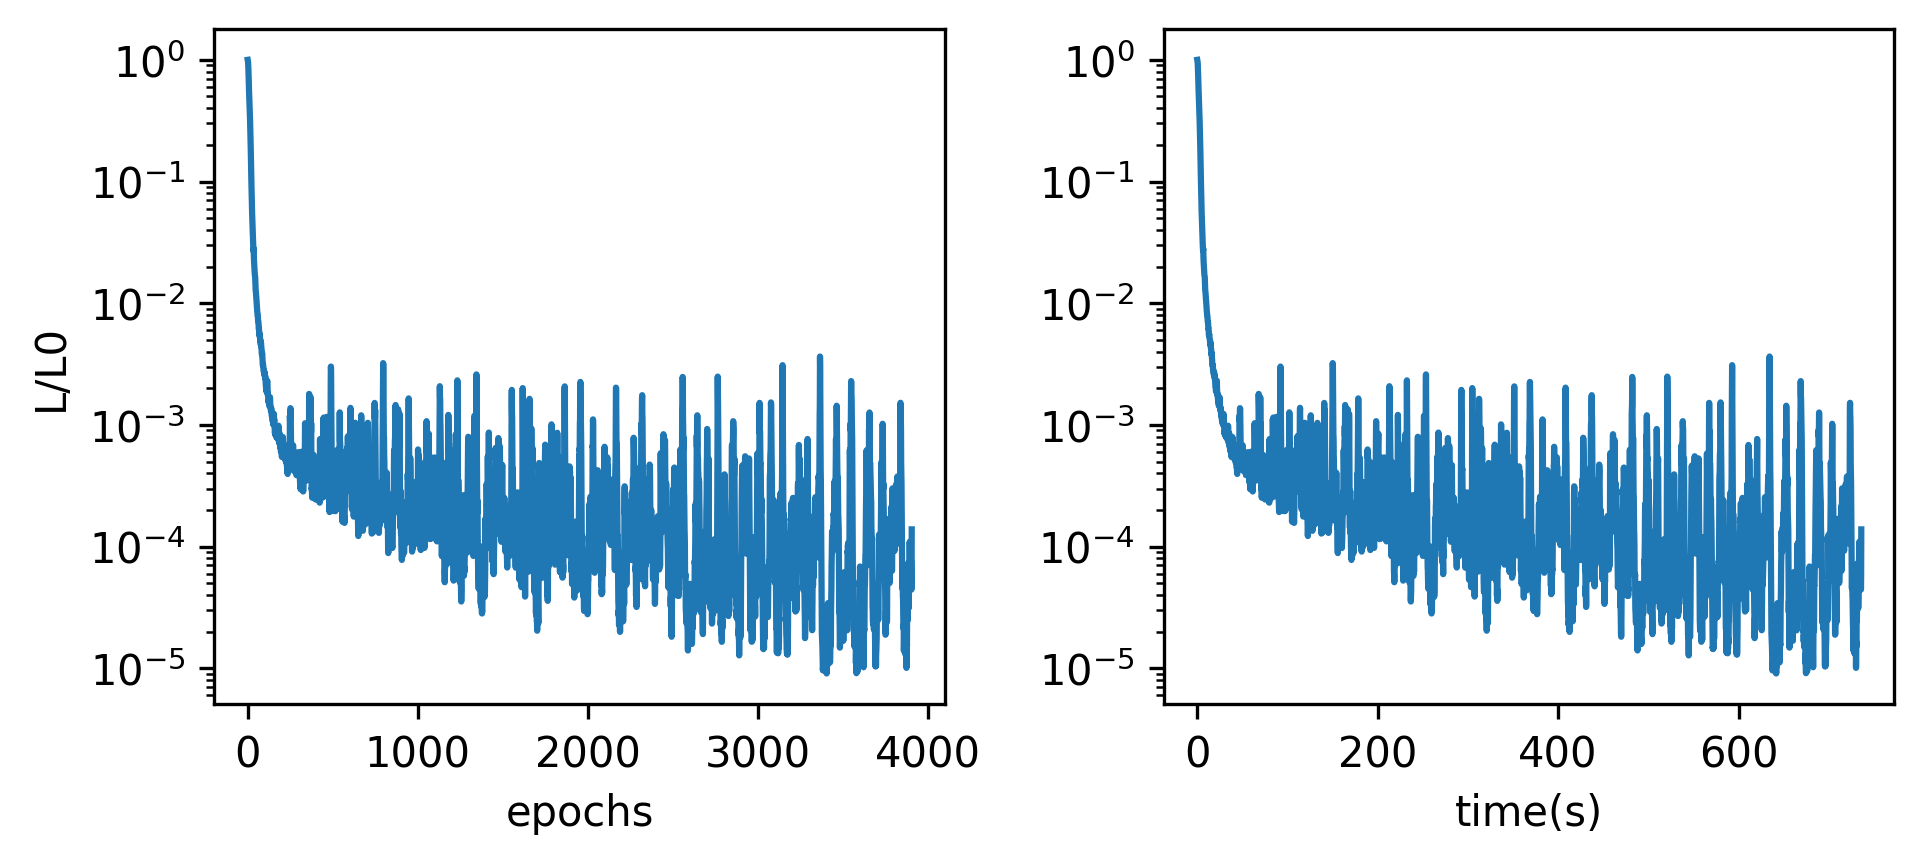

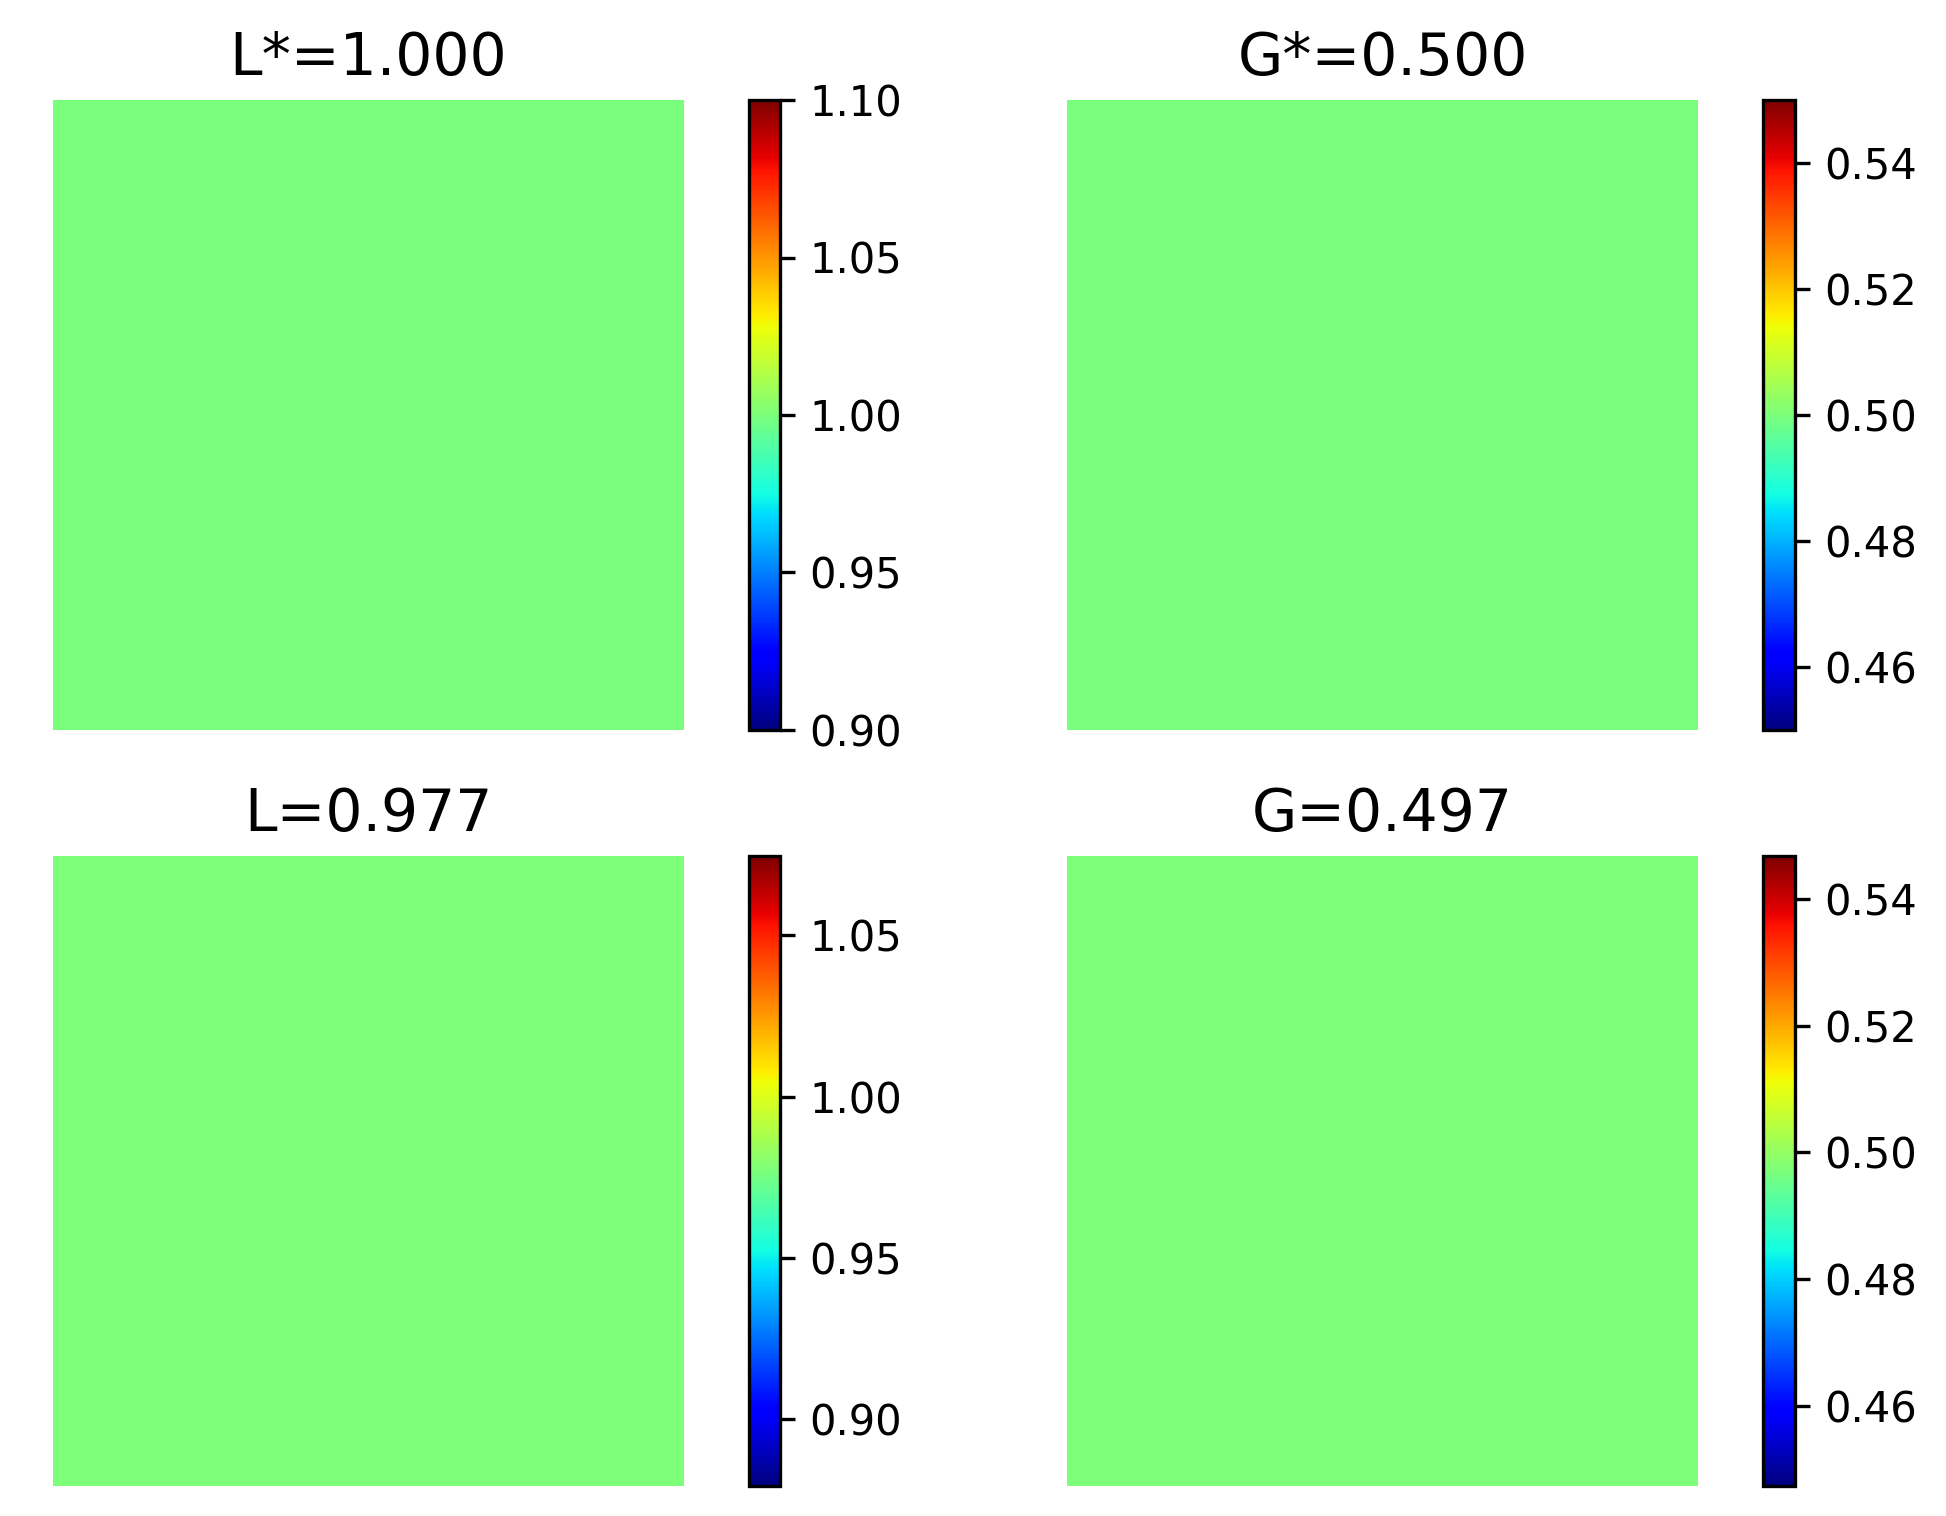

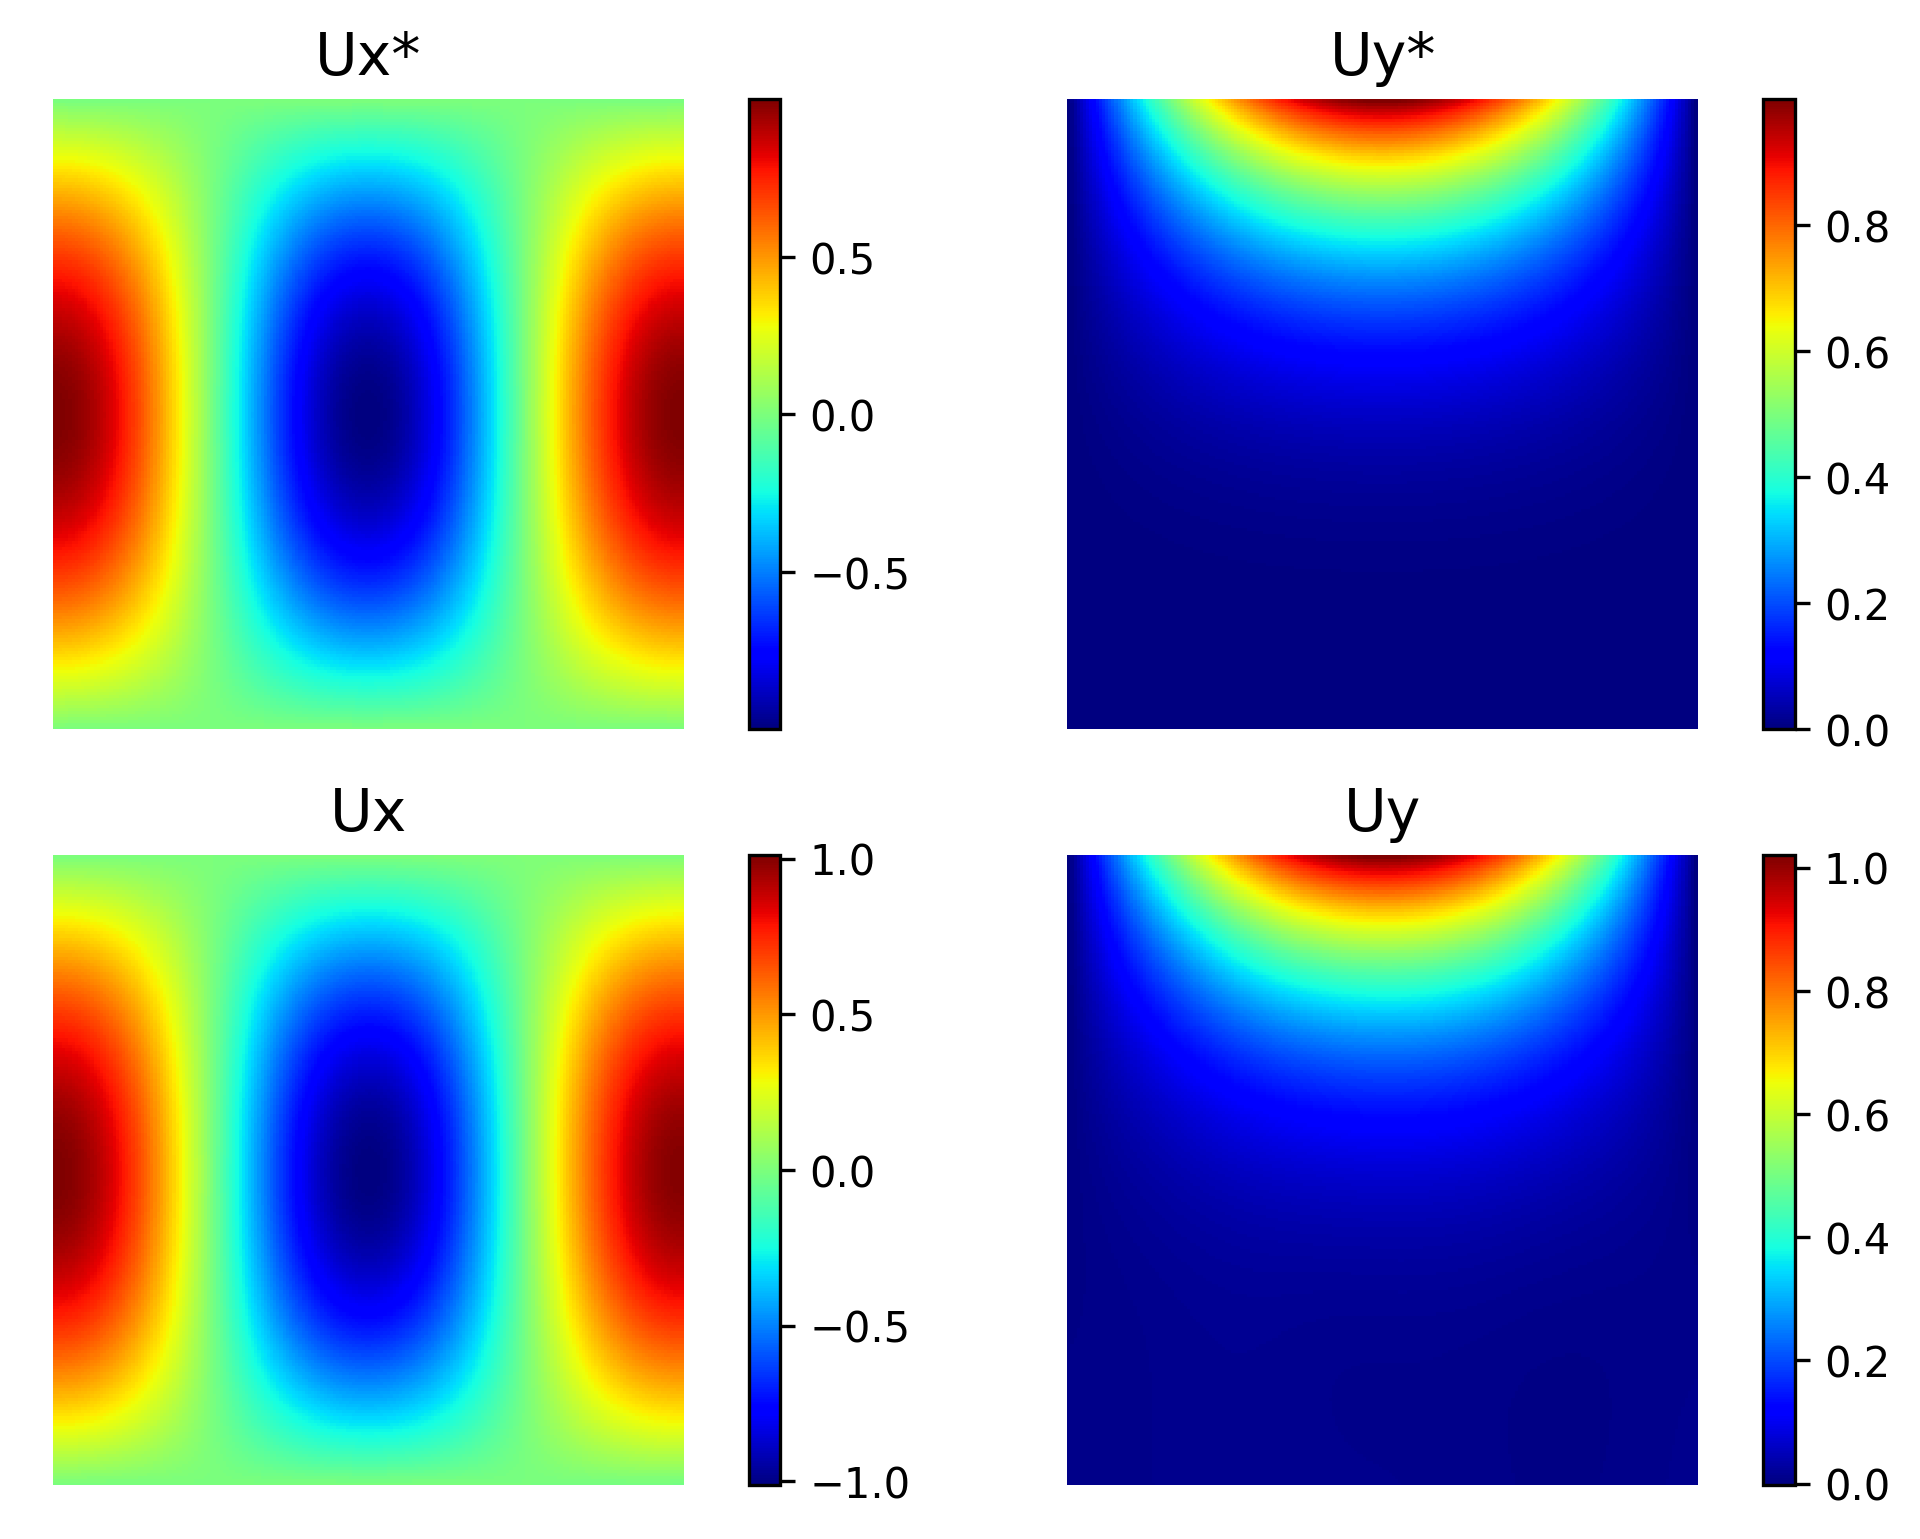

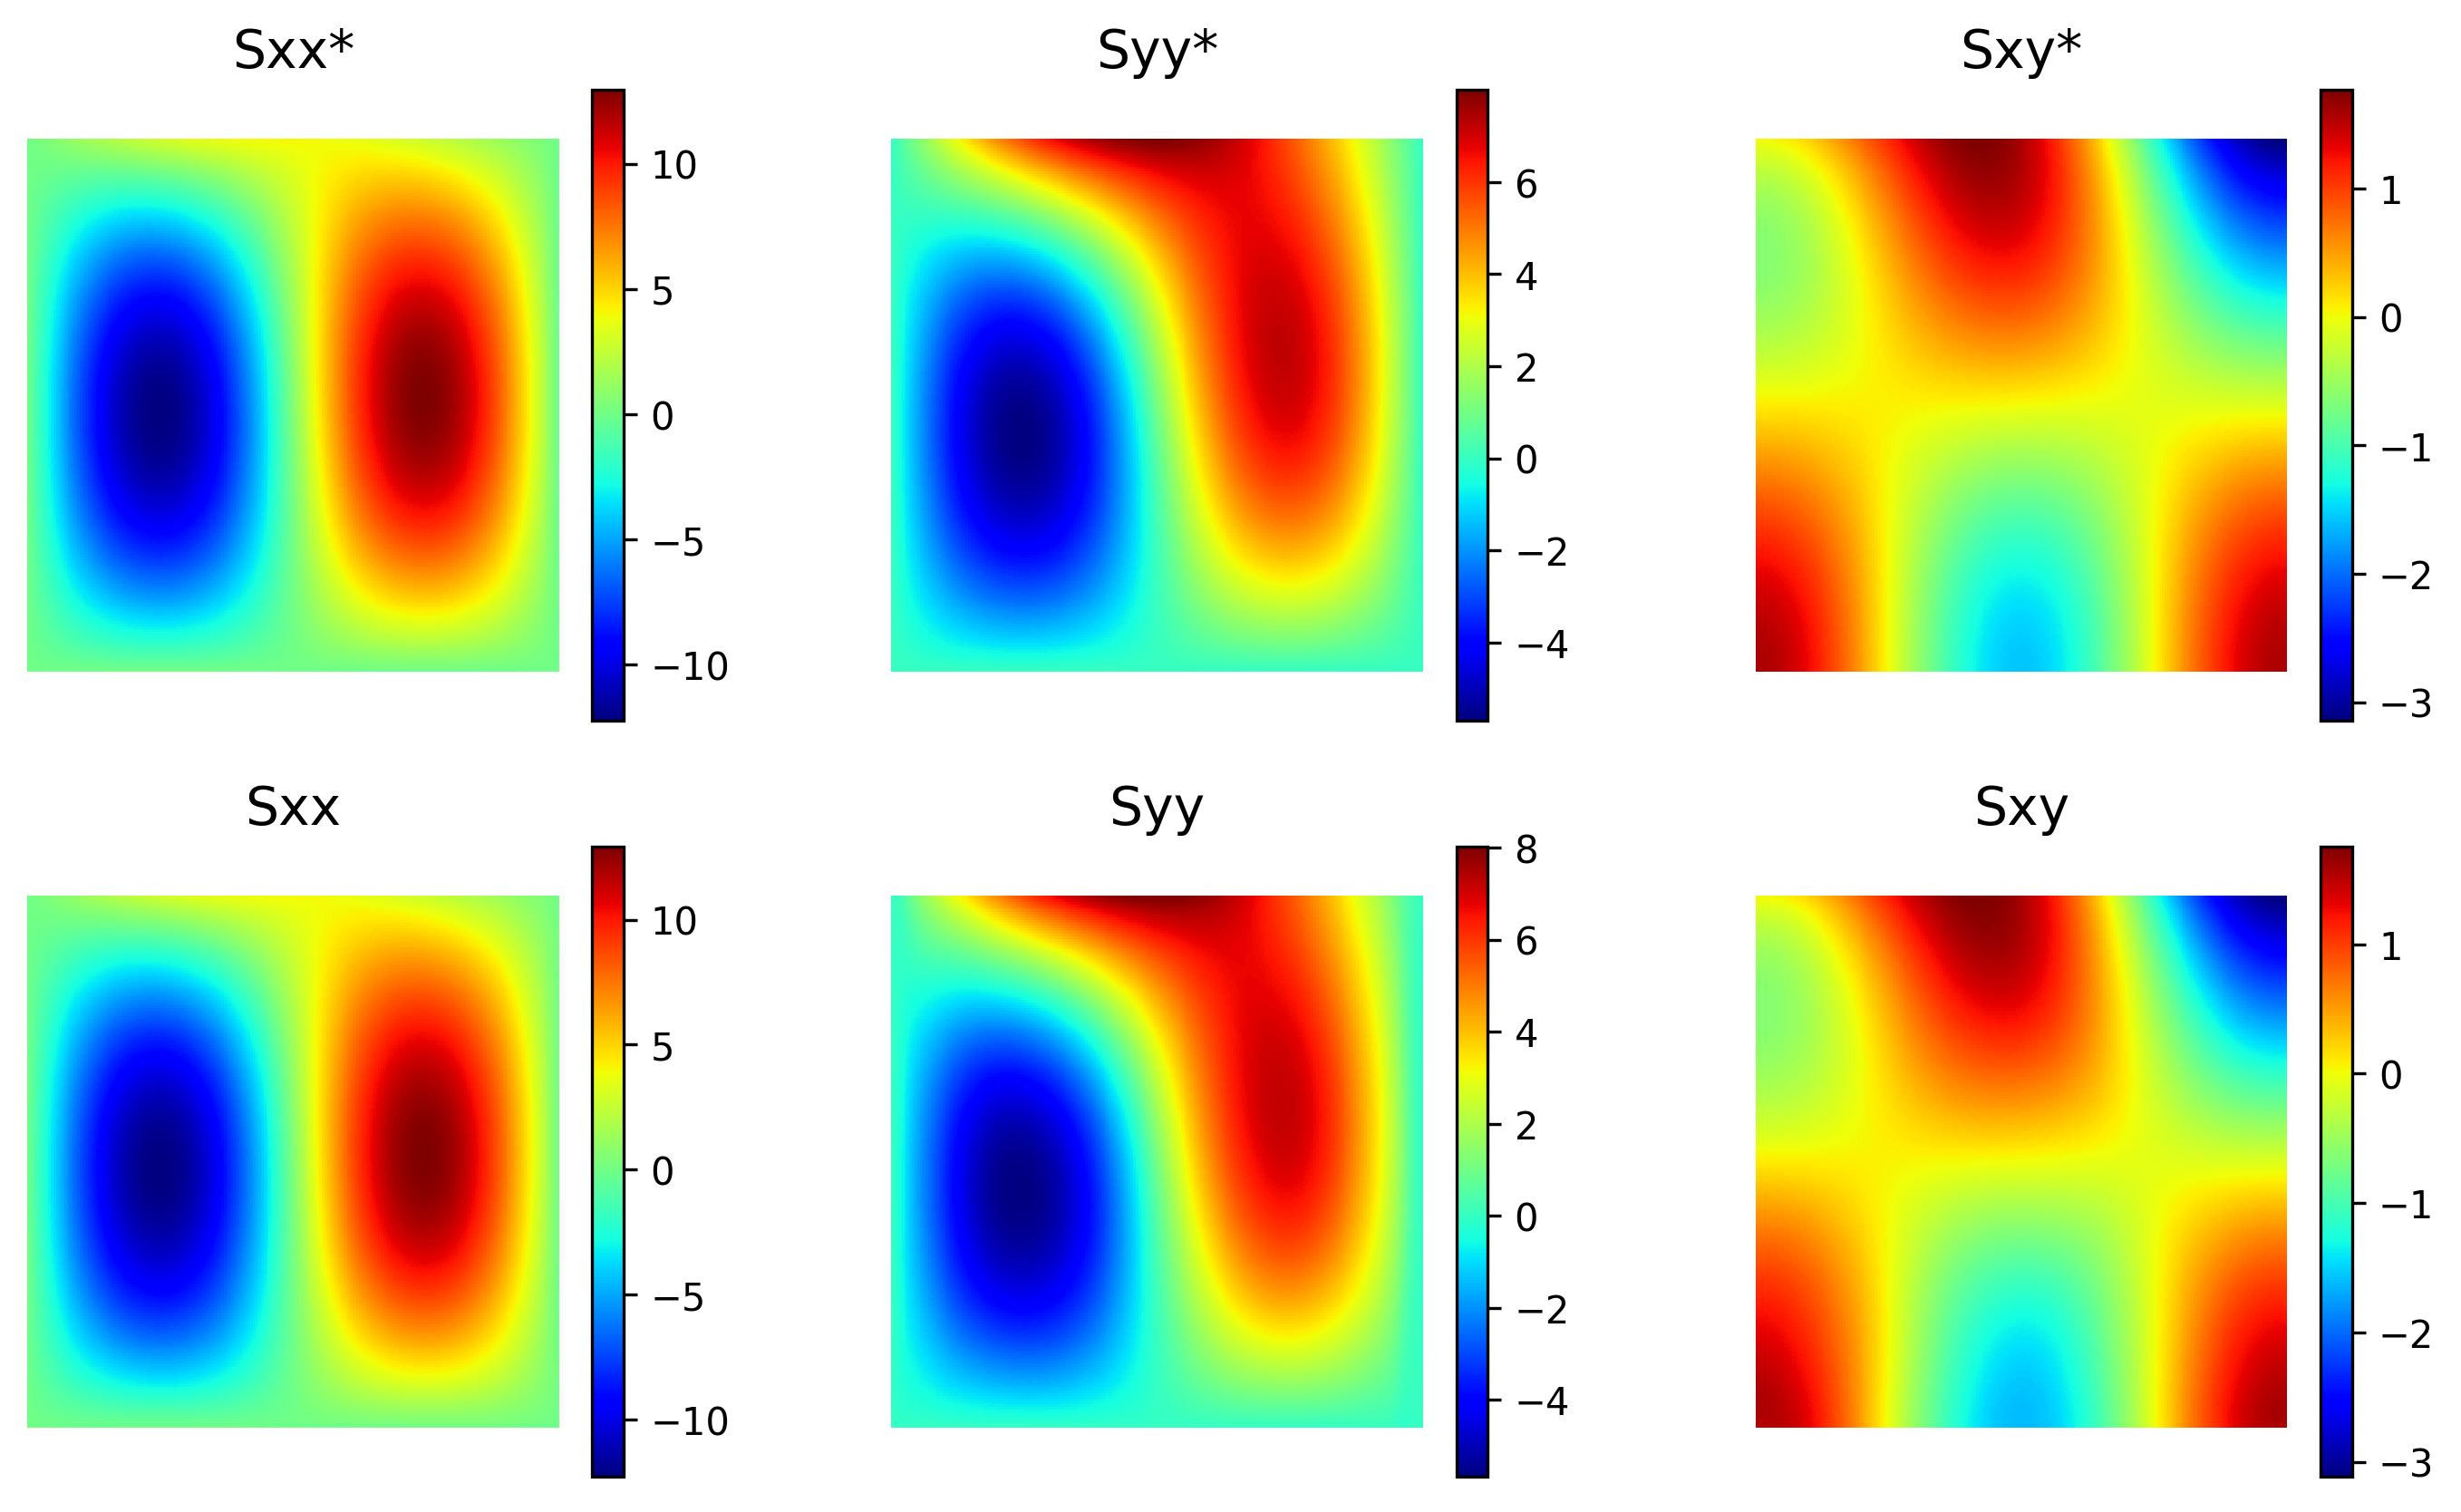

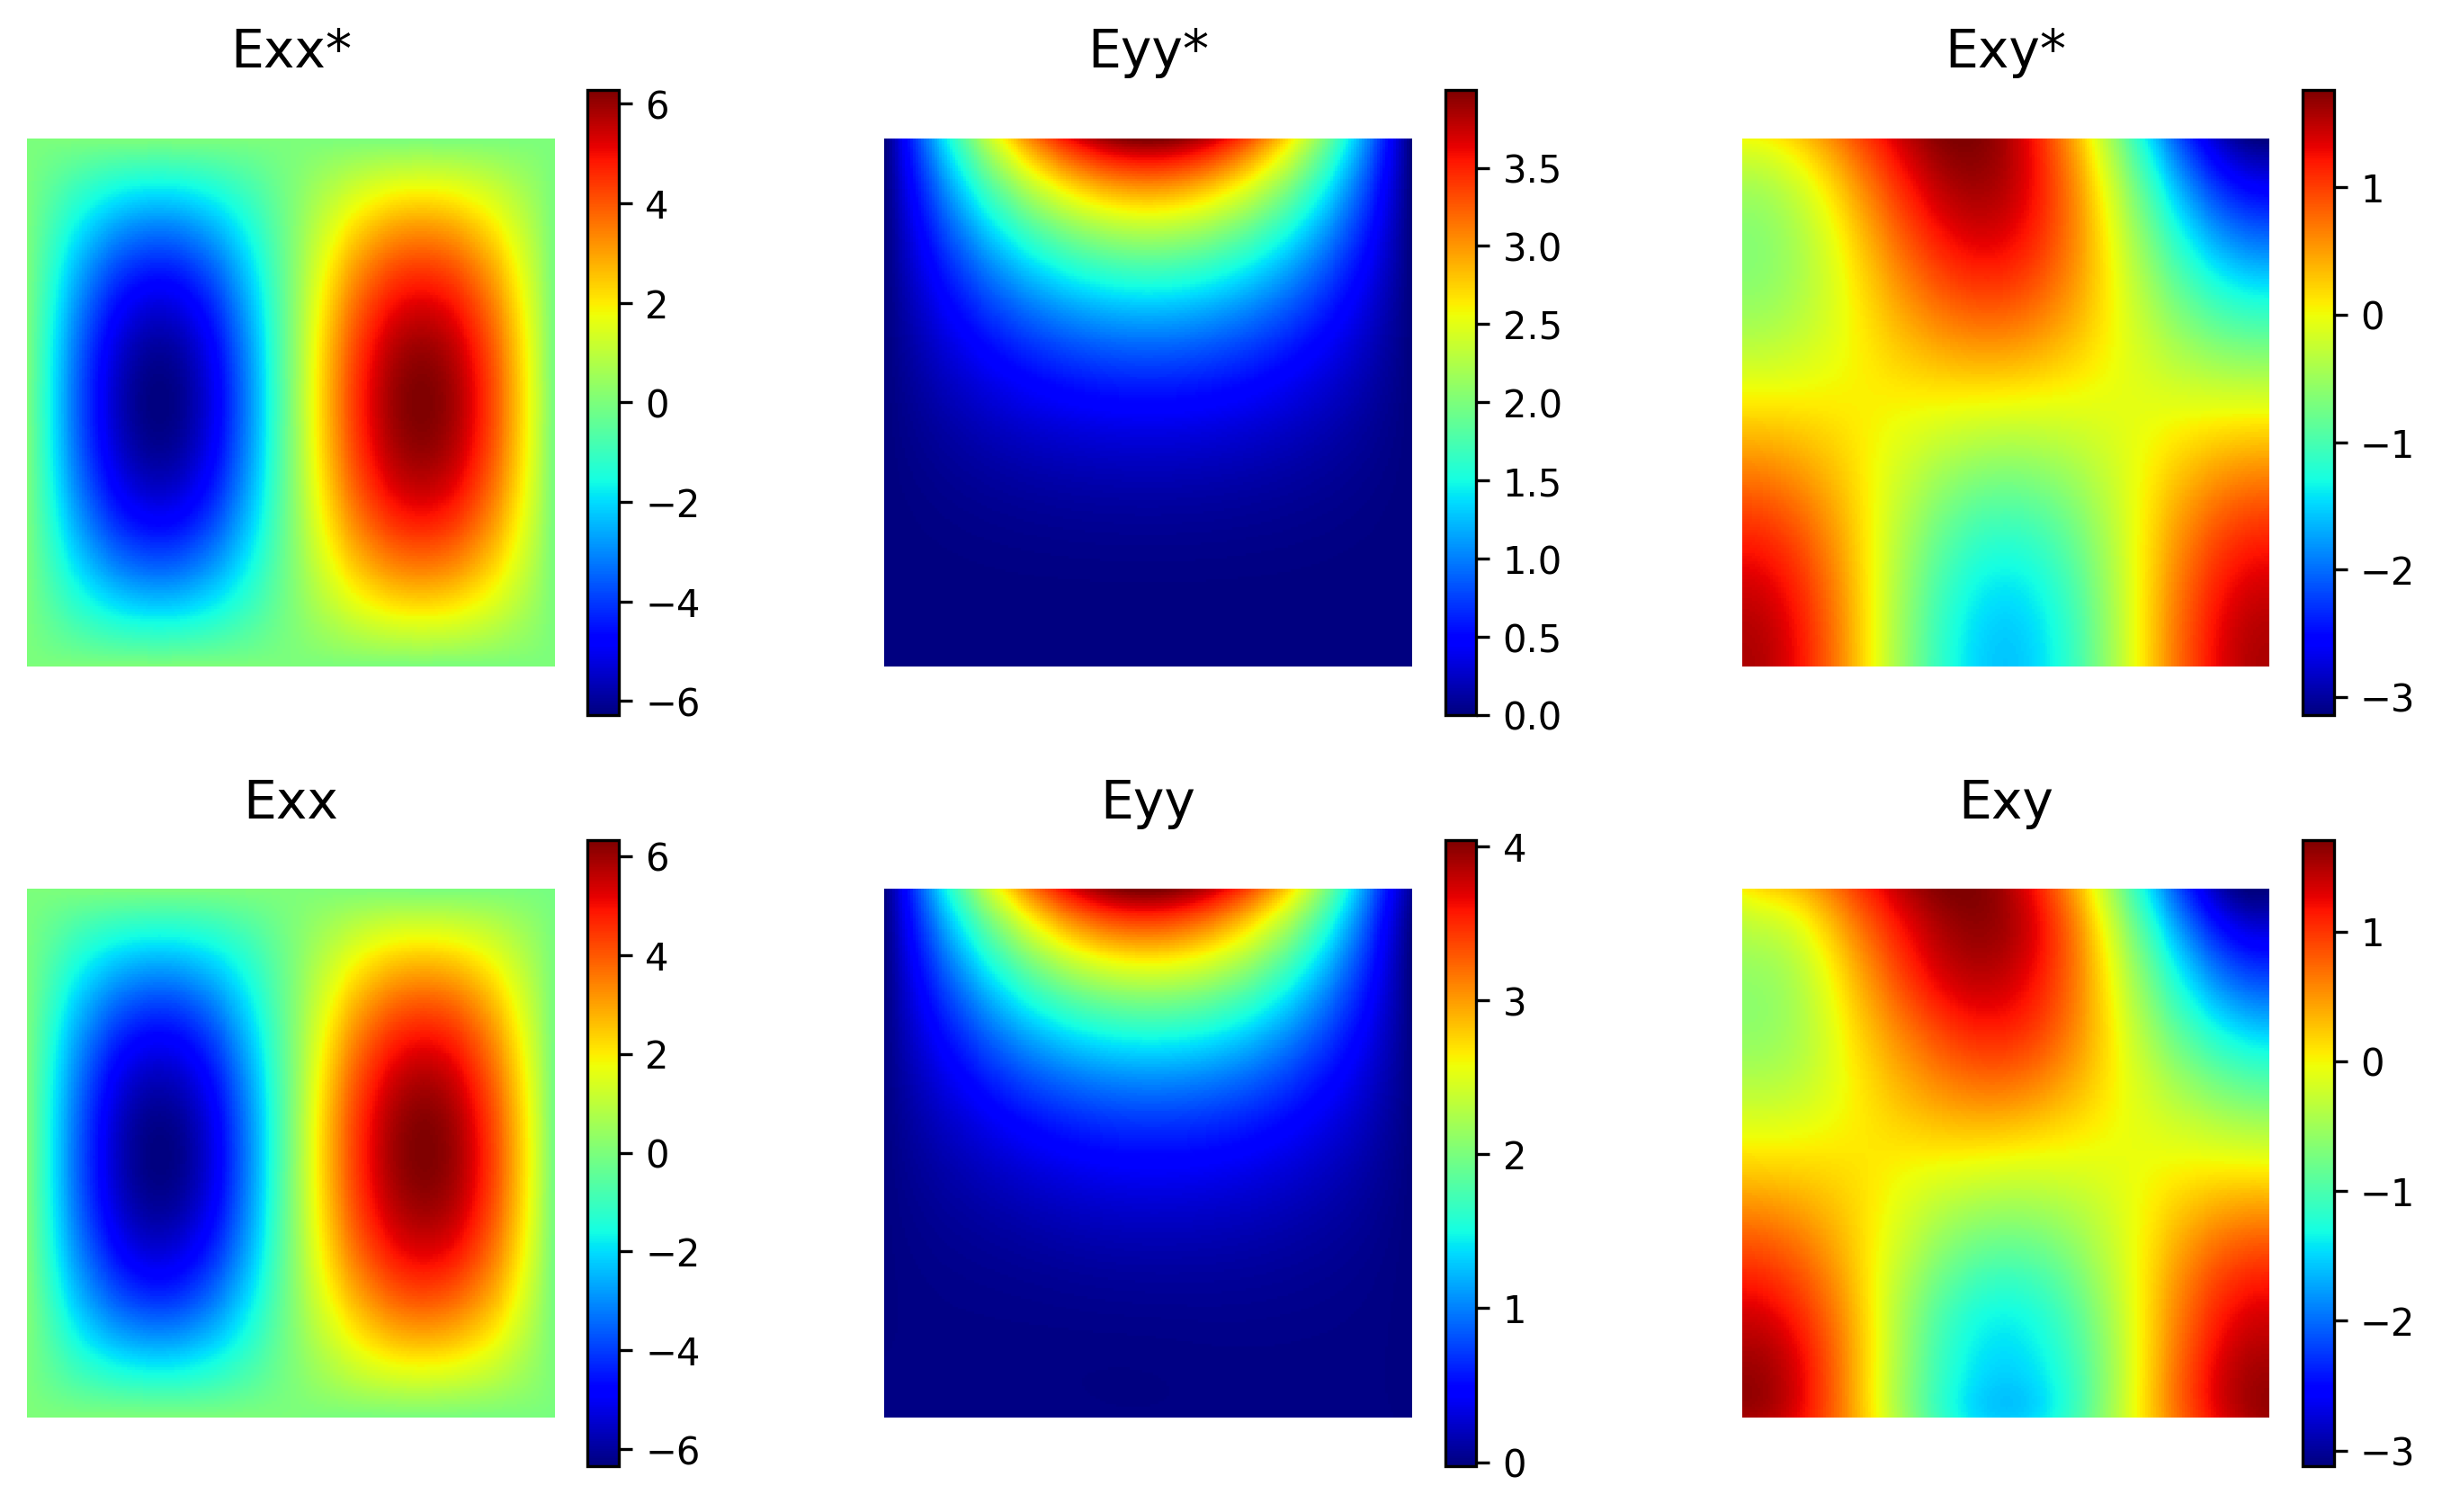

In [ ]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from sciann.utils.math import diff
from sciann import SciModel, Functional, Parameter, Variable, Data, Tie

pi = np.pi

# Parâmetros fixos do problema
lmbd = 1.0
mu = 0.5
qload = 4.0

# Configurações (simula argparse com dict)
args = {
    "layers": [40, 40, 40, 40],
    "actf": ["tanh"],
    "numx": [20],
    "numy": [20],
    "batchsize": [32],
    "epochs": [5000],
    "learningrate": [0.001],
    "independent_networks": [True],
    "verbose": [2],
    "shuffle": [True],
    "stopafter": [500],
    "savefreq": [100000],
    "dtype": ["float64"],
    "gpu": [False],
    "outputpath": ["output"],
    "outputprefix": ["res"],
    "numxplot": [200],
    "numyplot": [200],
    "plot": False,
}

if not args["gpu"][0]:
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Funções analíticas / auxiliares
def load(xx):
    x, y = xx[0], xx[1]
    Q = qload
    return Q * np.sin(pi*x)

def bodyfx(xx):
    x, y = xx[0], xx[1]
    Q = qload
    frc = - lmbd*(4*pi**2*np.cos(2*pi*x)*np.sin(pi*y) - Q*y**3*pi*np.cos(pi*x)) \
          - mu*(pi**2*np.cos(2*pi*x)*np.sin(pi*y) - Q*y**3*pi*np.cos(pi*x)) \
          - 8*mu*pi**2*np.cos(2*pi*x)*np.sin(pi*y)
    return frc

def bodyfy(xx):
    x, y = xx[0], xx[1]
    Q = qload
    frc = lmbd*(3*Q*y**2*np.sin(pi*x) - 2*pi**2*np.cos(pi*y)*np.sin(2*pi*x)) \
          - mu*(2*pi**2*np.cos(pi*y)*np.sin(2*pi*x) + (Q*y**4*pi**2*np.sin(pi*x))/4) \
          + 6*Q*mu*y**2*np.sin(pi*x)
    return frc

def dispx(xx):
    x, y = xx[0], xx[1]
    return np.cos(2*pi*x) * np.sin(pi*y)

def dispy(xx):
    x, y = xx[0], xx[1]
    Q = qload
    return np.sin(pi*x) * Q * y**4/4

def strainxx(xx):
    x, y = xx[0], xx[1]
    Q = qload
    return -2*pi*np.sin(2*pi*x)*np.sin(pi*y)

def strainyy(xx):
    x, y = xx[0], xx[1]
    Q = qload
    return np.sin(pi*x)*Q*y**3

def strainxy(xx):
    x, y = xx[0], xx[1]
    Q = qload
    return 0.5*(pi*np.cos(2*pi*x)*np.cos(pi*y) + pi*np.cos(pi*x)*Q*y**4/4)

def stressxx(xx):
    return (lmbd+2*mu)*strainxx(xx) + lmbd*strainyy(xx)

def stressyy(xx):
    return (lmbd+2*mu)*strainyy(xx) + lmbd*strainxx(xx)

def stressxy(xx):
    return 2.0*mu*strainxy(xx)

def cust_pcolor(AX, X, Y, C, title):
    im = AX.pcolor(X, Y, C, cmap="jet")
    AX.axis("equal")
    AX.axis("off")
    AX.set_title(title, fontsize=14)
    plt.colorbar(im, ax=AX)

def cust_semilogx(AX, X, Y, xlabel, ylabel):
    if X is None:
        im = AX.semilogy(Y)
    else:
        im = AX.semilogy(X, Y)
    if xlabel is not None: AX.set_xlabel(xlabel)
    if ylabel is not None: AX.set_ylabel(ylabel)

def train():
    # Prepare output folder
    if not os.path.isdir(args["outputpath"][0]):
        os.mkdir(args["outputpath"][0])

    output_file_name = os.path.join(args["outputpath"][0], args["outputprefix"][0])
    fname = output_file_name + "_{}_".format(args["actf"][0]) + "x".join([str(x) for x in args["layers"]])

    # Neural Network Setup
    x = Variable("x", dtype=args["dtype"][0])
    y = Variable("y", dtype=args["dtype"][0])

    if args["independent_networks"][0]:
        Uxy = Functional("Uxy", [x, y], args["layers"], args["actf"][0])
        Vxy = Functional("Vxy", [x, y], args["layers"], args["actf"][0])
        Sxx = Functional("Sxx", [x, y], args["layers"], args["actf"][0])
        Syy = Functional("Syy", [x, y], args["layers"], args["actf"][0])
        Sxy = Functional("Sxy", [x, y], args["layers"], args["actf"][0])
    else:
        Uxy, Vxy, Sxx, Syy, Sxy = Functional(
            ["Uxy", "Vxy", "Sxx", "Syy", "Sxy"],
            [x, y],
            args["layers"], args["actf"][0]).split()

    lame1 = Parameter(2.0, inputs=[x,y], name="lame1")
    lame2 = Parameter(2.0, inputs=[x,y], name="lame2")

    C11 = (2*lame2 + lame1)
    C12 = lame1
    C33 = 2*lame2

    Exx = diff(Uxy, x)
    Eyy = diff(Vxy, y)
    Exy = 0.5*(diff(Uxy, y) + diff(Vxy, x))

    # Define constraints
    d1 = Data(Uxy)
    d2 = Data(Vxy)
    d3 = Data(Sxx)
    d4 = Data(Syy)
    d5 = Data(Sxy)

    c1 = Tie(Sxx, Exx*C11 + Eyy*C12)
    c2 = Tie(Syy, Eyy*C11 + Exx*C12)
    c3 = Tie(Sxy, Exy*C33)

    Lx = diff(Sxx, x) + diff(Sxy, y)
    Ly = diff(Sxy, x) + diff(Syy, y)

    model = SciModel(
        inputs=[x, y],
        targets=[d1, d2, d3, d4, d5, c1, c2, c3, Lx, Ly],
        loss_func="mse"
    )

    with open(f"{fname}_summary", "w") as fobj:
        model.summary(print_fn=lambda x: fobj.write(x + '\n'))

    # Prepare training data
    XMIN, XMAX = 0.0, 1.0
    YMIN, YMAX = 0.0, 1.0
    Xmesh = np.linspace(XMIN, XMAX, args["numx"][0]).reshape((-1, 1))
    Ymesh = np.linspace(YMIN, YMAX, args["numy"][0]).reshape((-1, 1))
    X, Y = np.meshgrid(Xmesh, Ymesh)

    input_data = [X.reshape(-1, 1), Y.reshape(-1, 1)]

    XTOL, YTOL = np.array([XMAX-XMIN, YMAX-YMIN])*1e-6
    left_ids = np.where(abs(input_data[0] - XMIN) < XTOL)[0]
    right_ids = np.where(abs(input_data[0] - XMAX) < XTOL)[0]
    bot_ids = np.where(abs(input_data[1] - YMIN) < YTOL)[0]
    top_ids = np.where(abs(input_data[1] - YMAX) < YTOL)[0]
    BC_ids = np.unique(np.concatenate([left_ids, right_ids, bot_ids, top_ids]))

    data_d1 = dispx(input_data)
    data_d2 = dispy(input_data)
    data_d3 = stressxx(input_data)
    data_d4 = stressyy(input_data)
    data_d5 = stressxy(input_data)
    data_c1 = 'zeros'
    data_c2 = 'zeros'
    data_c3 = 'zeros'
    data_Lx = bodyfx(input_data)
    data_Ly = bodyfy(input_data)

    target_data = [
        (BC_ids, data_d1),
        (BC_ids, data_d2),
        (BC_ids, data_d3),
        (BC_ids, data_d4),
        (BC_ids, data_d5),
        data_c1, data_c2, data_c3,
        data_Lx, data_Ly
    ]

    print("Training started...")
    start = time.time()

    history = model.train(
        x_true=input_data,
        y_true=target_data,
        epochs=args["epochs"][0],
        batch_size=args["batchsize"][0],
        shuffle=args["shuffle"][0],
        learning_rate=args["learningrate"][0],
        stop_after=args["stopafter"][0],
        verbose=args["verbose"][0]
    )

    duration = time.time() - start
    print(f"Training finished in {duration:.2f} seconds.")

    weights_file = f"{fname}_WEIGHTS.h5"
    model.save_weights(weights_file)
    print(f"Weights saved in {weights_file}")

    # Save losses and times
    for loss_name in history.history:
        np.savetxt(f"{fname}_{loss_name.replace('/', '_')}.txt", np.array(history.history[loss_name]).reshape(-1, 1))
    np.savetxt(f"{fname}_Time.txt", np.linspace(0, duration, len(history.history["loss"])).reshape(-1, 1))

    # Post-process: evaluate model fields on fine grid and save
    Xmesh_plot = np.linspace(XMIN, XMAX, args["numxplot"][0]).reshape((-1, 1))
    Ymesh_plot = np.linspace(YMIN, YMAX, args["numyplot"][0]).reshape((-1, 1))
    X_plot, Y_plot = np.meshgrid(Xmesh_plot, Ymesh_plot)
    input_plot = [X_plot.reshape(-1, 1), Y_plot.reshape(-1, 1)]

    lame1_pred = lame1.eval(model, input_plot)
    lame2_pred = lame2.eval(model, input_plot)
    Uxy_pred = Uxy.eval(model, input_plot)
    Vxy_pred = Vxy.eval(model, input_plot)
    Exx_pred = Exx.eval(model, input_plot)
    Eyy_pred = Eyy.eval(model, input_plot)
    Exy_pred = Exy.eval(model, input_plot)
    Sxx_pred = Sxx.eval(model, input_plot)
    Syy_pred = Syy.eval(model, input_plot)
    Sxy_pred = Sxy.eval(model, input_plot)

    np.savetxt(f"{fname}_Xmesh.txt", X_plot, delimiter=', ')
    np.savetxt(f"{fname}_Ymesh.txt", Y_plot, delimiter=', ')
    np.savetxt(f"{fname}_lame1.txt", lame1_pred, delimiter=', ')
    np.savetxt(f"{fname}_lame2.txt", lame2_pred, delimiter=', ')
    np.savetxt(f"{fname}_Uxy.txt", Uxy_pred.reshape(X_plot.shape), delimiter=', ')
    np.savetxt(f"{fname}_Vxy.txt", Vxy_pred.reshape(X_plot.shape), delimiter=', ')
    np.savetxt(f"{fname}_Exx.txt", Exx_pred.reshape(X_plot.shape), delimiter=', ')
    np.savetxt(f"{fname}_Eyy.txt", Eyy_pred.reshape(X_plot.shape), delimiter=', ')
    np.savetxt(f"{fname}_Exy.txt", Exy_pred.reshape(X_plot.shape), delimiter=', ')
    np.savetxt(f"{fname}_Sxx.txt", Sxx_pred.reshape(X_plot.shape), delimiter=', ')
    np.savetxt(f"{fname}_Syy.txt", Syy_pred.reshape(X_plot.shape), delimiter=', ')
    np.savetxt(f"{fname}_Sxy.txt", Sxy_pred.reshape(X_plot.shape), delimiter=', ')

def plot():
    output_file_name = os.path.join(args["outputpath"][0], args["outputprefix"][0])
    fname = output_file_name + "_{}_".format(args["actf"][0]) + "x".join([str(x) for x in args["layers"]])

    loss = np.loadtxt(f"{fname}_loss.txt")
    time = np.loadtxt(f"{fname}_Time.txt")
    fig, ax = plt.subplots(1, 2, figsize=(7, 3), dpi=300)
    cust_semilogx(ax[0], None, loss/loss[0], "epochs", "L/L0")
    cust_semilogx(ax[1], time, loss/loss[0], "time(s)", None)
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.9, wspace=0.3, hspace=0.2)
    plt.savefig(f"{output_file_name}_loss.png")
    plt.show()

    Xmesh = np.loadtxt(f"{fname}_Xmesh.txt", delimiter=',')
    Ymesh = np.loadtxt(f"{fname}_Ymesh.txt", delimiter=',')

    fig, ax = plt.subplots(2, 2, figsize=(8, 6), dpi=300)
    cust_pcolor(ax[0, 0], Xmesh, Ymesh, np.ones_like(Xmesh)*lmbd, f"L*={lmbd:.3f}")
    cust_pcolor(ax[0, 1], Xmesh, Ymesh, np.ones_like(Xmesh)*mu, f"G*={mu:.3f}")
    lmbd_pred = np.loadtxt(f"{fname}_lame1.txt", delimiter=',')
    mu_pred = np.loadtxt(f"{fname}_lame2.txt", delimiter=',')
    cust_pcolor(ax[1, 0], Xmesh, Ymesh, np.ones_like(Xmesh)*lmbd_pred, f"L={lmbd_pred.mean():.3f}")
    cust_pcolor(ax[1, 1], Xmesh, Ymesh, np.ones_like(Xmesh)*mu_pred, f"G={mu_pred.mean():.3f}")
    plt.savefig(f"{output_file_name}_Parameters.png")
    plt.show()

    fig, ax = plt.subplots(2, 2, figsize=(8, 6), dpi=300)
    cust_pcolor(ax[0, 0], Xmesh, Ymesh, dispx([Xmesh, Ymesh]), "Ux*")
    cust_pcolor(ax[0, 1], Xmesh, Ymesh, dispy([Xmesh, Ymesh]), "Uy*")
    cust_pcolor(ax[1, 0], Xmesh, Ymesh, np.loadtxt(f"{fname}_Uxy.txt", delimiter=','), "Ux")
    cust_pcolor(ax[1, 1], Xmesh, Ymesh, np.loadtxt(f"{fname}_Vxy.txt", delimiter=','), "Uy")
    plt.savefig(f"{output_file_name}_Displacement.png")
    plt.show()

    fig, ax = plt.subplots(2, 3, figsize=(11, 6), dpi=300)
    cust_pcolor(ax[0, 0], Xmesh, Ymesh, stressxx([Xmesh, Ymesh]), "Sxx*")
    cust_pcolor(ax[0, 1], Xmesh, Ymesh, stressyy([Xmesh, Ymesh]), "Syy*")
    cust_pcolor(ax[0, 2], Xmesh, Ymesh, stressxy([Xmesh, Ymesh]), "Sxy*")
    cust_pcolor(ax[1, 0], Xmesh, Ymesh, np.loadtxt(f"{fname}_Sxx.txt", delimiter=','), "Sxx")
    cust_pcolor(ax[1, 1], Xmesh, Ymesh, np.loadtxt(f"{fname}_Syy.txt", delimiter=','), "Syy")
    cust_pcolor(ax[1, 2], Xmesh, Ymesh, np.loadtxt(f"{fname}_Sxy.txt", delimiter=','), "Sxy")
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.05, top=0.9, wspace=0.3, hspace=0.2)
    plt.savefig(f"{output_file_name}_Stress.png")
    plt.show()

    fig, ax = plt.subplots(2, 3, figsize=(11, 6), dpi=300)
    cust_pcolor(ax[0, 0], Xmesh, Ymesh, strainxx([Xmesh, Ymesh]), "Exx*")
    cust_pcolor(ax[0, 1], Xmesh, Ymesh, strainyy([Xmesh, Ymesh]), "Eyy*")
    cust_pcolor(ax[0, 2], Xmesh, Ymesh, strainxy([Xmesh, Ymesh]), "Exy*")
    cust_pcolor(ax[1, 0], Xmesh, Ymesh, np.loadtxt(f"{fname}_Exx.txt", delimiter=','), "Exx")
    cust_pcolor(ax[1, 1], Xmesh, Ymesh, np.loadtxt(f"{fname}_Eyy.txt", delimiter=','), "Eyy")
    cust_pcolor(ax[1, 2], Xmesh, Ymesh, np.loadtxt(f"{fname}_Exy.txt", delimiter=','), "Exy")
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.05, top=0.9, wspace=0.3, hspace=0.2)
    plt.savefig(f"{output_file_name}_Strain.png")
    plt.show()

if __name__ == "__main__":
    train()
    plot()
